In [18]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [19]:
sys.path.insert(0,"../python/rrvf2017/")

In [20]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [21]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (54, 829, 517)


(62, (829, 517, 62))

In [22]:
gc.collect()

19

In [23]:
#show_data(data,columns, 1,480, None)

In [24]:
#show_data2(data,columns)

# cv

In [25]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [26]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [27]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'station_count_y3', 'station_count_y4'])
len(lag_cols)

27

In [12]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG'])

In [14]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=[pickle.load(open(u)) for  u in ['train_idx_1.pkl','train_idx_2.pkl','train_idx_3.pkl']]

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy)
        d_valid = lgb.Dataset(validX, label=validy)
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=478-39)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
def _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [31]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=0
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    _,validpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('lgb_valid{}_preds_tmp.pkl'.format(j),'wb'))



1
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 316728 records out of 351496 records
valid has 34768 records out of 351496 records
train has 5803 records out of 5803 records
no valid set
2474
0
(316728, 1, 6) (316728, 7, 27) (316728, 1) (316728, 1)
(316728, 195) (316728,) (316728,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


(34768, 1, 6) (34768, 7, 27) (34768, 1) (34768, 1)
(34768, 195) (34768,) (34768,)
(5803, 1, 6) (5803, 7, 27) (5803, 1) (5803, 1)
(5803, 195) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.827948
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.804613
[3]	valid_0's rmse: 0.782825
[4]	valid_0's rmse: 0.762604
[5]	valid_0's rmse: 0.743702
[6]	valid_0's rmse: 0.726329
[7]	valid_0's rmse: 0.710151
[8]	valid_0's rmse: 0.694965
[9]	valid_0's rmse: 0.681047
[10]	valid_0's rmse: 0.667768
[11]	valid_0's rmse: 0.655773
[12]	valid_0's rmse: 0.644452
[13]	valid_0's rmse: 0.634206
[14]	valid_0's rmse: 0.624713
[15]	

[251]	valid_0's rmse: 0.497082
[252]	valid_0's rmse: 0.497031
[253]	valid_0's rmse: 0.497025
[254]	valid_0's rmse: 0.497039
[255]	valid_0's rmse: 0.497002
[256]	valid_0's rmse: 0.497004
[257]	valid_0's rmse: 0.496968
[258]	valid_0's rmse: 0.496965
[259]	valid_0's rmse: 0.496947
[260]	valid_0's rmse: 0.496932
[261]	valid_0's rmse: 0.496885
[262]	valid_0's rmse: 0.496866
[263]	valid_0's rmse: 0.496837
[264]	valid_0's rmse: 0.49681
[265]	valid_0's rmse: 0.496794
[266]	valid_0's rmse: 0.49682
[267]	valid_0's rmse: 0.496815
[268]	valid_0's rmse: 0.496806
[269]	valid_0's rmse: 0.496823
[270]	valid_0's rmse: 0.496805
[271]	valid_0's rmse: 0.496782
[272]	valid_0's rmse: 0.496791
[273]	valid_0's rmse: 0.496811
[274]	valid_0's rmse: 0.49684
[275]	valid_0's rmse: 0.496833
[276]	valid_0's rmse: 0.496843
[277]	valid_0's rmse: 0.496875
[278]	valid_0's rmse: 0.496894
[279]	valid_0's rmse: 0.496873
[280]	valid_0's rmse: 0.496869
[281]	valid_0's rmse: 0.496859
[282]	valid_0's rmse: 0.49687
[283]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894070  0.035040  0.271135    7  2017-04-16
472     2.507290  2.603843 -0.096552  0.263626    1  2017-04-17
473     2.661330  2.636209  0.025121  0.283461    2  2017-04-18
474     2.754815  2.699278  0.055537  0.240287    3  2017-04-19
475     2.713762  2.637847  0.075915  0.271582    4  2017-04-20
476     2.999000  2.970406  0.028593  0.166558    5  2017-04-21
477     3.075529  3.116956 -0.041427  0.205610    6  2017-04-22

0.243180029396


pred         y     error    error2  day        date
dayidx                                                         
471     2.894070  2.929110  0.035040  0.271135    7  2017-04-16
472     2.603843  2.507290 -0.096552  0.263626    1  2017-04-17
473     2.636209  2.661330  0.025121  0.283461    2  2017-04-18
474     2.699278  2.754815  0.055537  0.240287    3  2017-04-19
475     2.637847  2.713762  0.075915  0.271582    4  2017-04-20
476     2.970406  2.999000  0.028593  0.166558    5  2017-04-21
477     3.116956  3.075529 -0.041427  0.205610    6  2017-04-22

(829, 195)


2
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 315981 records out of 350667 records
valid has 34686 records out of 350667 records
train has 6632 records out of 6632 records
no valid set
2468
0
(315981, 1, 6) (315981, 7, 27) (315981, 1) (315981, 1)
(315981, 195) (315981,) (315981,)
(34686, 1, 6) (34686, 7, 27) (34686, 1) (34686, 1)
(34686, 195) (34686,) (34686,)
(6632, 1, 6) (6632, 7, 27) (6632, 1) (6632, 1)
(6632, 195) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.828106
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.80487
[3]	valid_0's rmse: 0.78

[241]	valid_0's rmse: 0.499866
[242]	valid_0's rmse: 0.499872
[243]	valid_0's rmse: 0.499837
[244]	valid_0's rmse: 0.499851
[245]	valid_0's rmse: 0.499831
[246]	valid_0's rmse: 0.499806
[247]	valid_0's rmse: 0.499823
[248]	valid_0's rmse: 0.499809
[249]	valid_0's rmse: 0.49982
[250]	valid_0's rmse: 0.499827
[251]	valid_0's rmse: 0.499823
[252]	valid_0's rmse: 0.499846
[253]	valid_0's rmse: 0.499837
[254]	valid_0's rmse: 0.499846
[255]	valid_0's rmse: 0.499822
[256]	valid_0's rmse: 0.499792
[257]	valid_0's rmse: 0.499774
[258]	valid_0's rmse: 0.499751
[259]	valid_0's rmse: 0.499747
[260]	valid_0's rmse: 0.499728
[261]	valid_0's rmse: 0.499685
[262]	valid_0's rmse: 0.499643
[263]	valid_0's rmse: 0.499645
[264]	valid_0's rmse: 0.499661
[265]	valid_0's rmse: 0.499573
[266]	valid_0's rmse: 0.499588
[267]	valid_0's rmse: 0.499625
[268]	valid_0's rmse: 0.499562
[269]	valid_0's rmse: 0.499551
[270]	valid_0's rmse: 0.499556
[271]	valid_0's rmse: 0.499555
[272]	valid_0's rmse: 0.499536
[273]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.866332  0.062778  0.265125    7  2017-04-16
472     2.507290  2.610793 -0.103502  0.263289    1  2017-04-17
473     2.661330  2.617269  0.044061  0.279864    2  2017-04-18
474     2.754815  2.688339  0.066475  0.245015    3  2017-04-19
475     2.713762  2.662516  0.051245  0.265652    4  2017-04-20
476     2.999000  2.962218  0.036782  0.170299    5  2017-04-21
477     3.075529  3.108564 -0.033034  0.206518    6  2017-04-22

0.242251754504


pred         y     error    error2  day        date
dayidx                                                         
471     2.866332  2.929110  0.062778  0.265125    7  2017-04-16
472     2.610793  2.507290 -0.103502  0.263289    1  2017-04-17
473     2.617269  2.661330  0.044061  0.279864    2  2017-04-18
474     2.688339  2.754815  0.066475  0.245015    3  2017-04-19
475     2.662516  2.713762  0.051245  0.265652    4  2017-04-20
476     2.962218  2.999000  0.036782  0.170299    5  2017-04-21
477     3.108564  3.075529 -0.033034  0.206518    6  2017-04-22

(829, 195)


3
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 315234 records out of 349838 records
valid has 34604 records out of 349838 records
train has 7461 records out of 7461 records
no valid set
2462
0
(315234, 1, 6) (315234, 7, 27) (315234, 1) (315234, 1)
(315234, 195) (315234,) (315234,)
(34604, 1, 6) (34604, 7, 27) (34604, 1) (34604, 1)
(34604, 195) (34604,) (34604,)
(7461, 1, 6) (7461, 7, 27) (7461, 1) (7461, 1)
(7461, 195) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.828421
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.805278
[3]	valid_0's rmse: 0.7

[241]	valid_0's rmse: 0.501124
[242]	valid_0's rmse: 0.501104
[243]	valid_0's rmse: 0.501101
[244]	valid_0's rmse: 0.501148
[245]	valid_0's rmse: 0.501148
[246]	valid_0's rmse: 0.50117
[247]	valid_0's rmse: 0.501155
[248]	valid_0's rmse: 0.501177
[249]	valid_0's rmse: 0.501177
[250]	valid_0's rmse: 0.501179
[251]	valid_0's rmse: 0.50119
[252]	valid_0's rmse: 0.50119
[253]	valid_0's rmse: 0.501166
[254]	valid_0's rmse: 0.501142
[255]	valid_0's rmse: 0.501134
[256]	valid_0's rmse: 0.501152
[257]	valid_0's rmse: 0.501138
[258]	valid_0's rmse: 0.50114
[259]	valid_0's rmse: 0.501104
[260]	valid_0's rmse: 0.501086
[261]	valid_0's rmse: 0.501082
[262]	valid_0's rmse: 0.501069
[263]	valid_0's rmse: 0.501071
[264]	valid_0's rmse: 0.501039
[265]	valid_0's rmse: 0.501016
[266]	valid_0's rmse: 0.501004
[267]	valid_0's rmse: 0.500997
[268]	valid_0's rmse: 0.501006
[269]	valid_0's rmse: 0.501004
[270]	valid_0's rmse: 0.500976
[271]	valid_0's rmse: 0.501026
[272]	valid_0's rmse: 0.501008
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.871868  0.057242  0.271212    7  2017-04-16
472     2.507290  2.624616 -0.117326  0.269066    1  2017-04-17
473     2.661330  2.613925  0.047405  0.284665    2  2017-04-18
474     2.754815  2.700695  0.054120  0.244524    3  2017-04-19
475     2.713762  2.634616  0.079146  0.275945    4  2017-04-20
476     2.999000  2.980435  0.018564  0.167444    5  2017-04-21
477     3.075529  3.106460 -0.030931  0.208040    6  2017-04-22

0.245842260802


pred         y     error    error2  day        date
dayidx                                                         
471     2.871868  2.929110  0.057242  0.271212    7  2017-04-16
472     2.624616  2.507290 -0.117326  0.269066    1  2017-04-17
473     2.613925  2.661330  0.047405  0.284665    2  2017-04-18
474     2.700695  2.754815  0.054120  0.244524    3  2017-04-19
475     2.634616  2.713762  0.079146  0.275945    4  2017-04-20
476     2.980435  2.999000  0.018564  0.167444    5  2017-04-21
477     3.106460  3.075529 -0.030931  0.208040    6  2017-04-22

(829, 195)


4
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 314487 records out of 349009 records
valid has 34522 records out of 349009 records
train has 8290 records out of 8290 records
no valid set
2456
0
(314487, 1, 6) (314487, 7, 27) (314487, 1) (314487, 1)
(314487, 195) (314487,) (314487,)
(34522, 1, 6) (34522, 7, 27) (34522, 1) (34522, 1)
(34522, 195) (34522,) (34522,)
(8290, 1, 6) (8290, 7, 27) (8290, 1) (8290, 1)
(8290, 195) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.827889
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.804893
[3]	valid_0's rmse: 0.7

[240]	valid_0's rmse: 0.501969
[241]	valid_0's rmse: 0.501972
[242]	valid_0's rmse: 0.501952
[243]	valid_0's rmse: 0.501954
[244]	valid_0's rmse: 0.501944
[245]	valid_0's rmse: 0.501951
[246]	valid_0's rmse: 0.50196
[247]	valid_0's rmse: 0.501958
[248]	valid_0's rmse: 0.501943
[249]	valid_0's rmse: 0.501966
[250]	valid_0's rmse: 0.501968
[251]	valid_0's rmse: 0.501913
[252]	valid_0's rmse: 0.501914
[253]	valid_0's rmse: 0.501912
[254]	valid_0's rmse: 0.501902
[255]	valid_0's rmse: 0.501893
[256]	valid_0's rmse: 0.501872
[257]	valid_0's rmse: 0.501838
[258]	valid_0's rmse: 0.501804
[259]	valid_0's rmse: 0.501825
[260]	valid_0's rmse: 0.50182
[261]	valid_0's rmse: 0.501837
[262]	valid_0's rmse: 0.501805
[263]	valid_0's rmse: 0.501791
[264]	valid_0's rmse: 0.501773
[265]	valid_0's rmse: 0.501774
[266]	valid_0's rmse: 0.501769
[267]	valid_0's rmse: 0.501751
[268]	valid_0's rmse: 0.501749
[269]	valid_0's rmse: 0.501715
[270]	valid_0's rmse: 0.501732
[271]	valid_0's rmse: 0.501705
[272]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.849257  0.079853  0.271755    7  2017-04-16
472     2.507290  2.614369 -0.107078  0.263109    1  2017-04-17
473     2.661330  2.627662  0.033668  0.284074    2  2017-04-18
474     2.754815  2.711599  0.043216  0.236005    3  2017-04-19
475     2.713762  2.682393  0.031369  0.271334    4  2017-04-20
476     2.999000  2.947844  0.051156  0.171745    5  2017-04-21
477     3.075529  3.097308 -0.021779  0.206173    6  2017-04-22

0.243456434345


pred         y     error    error2  day        date
dayidx                                                         
471     2.849257  2.929110  0.079853  0.271755    7  2017-04-16
472     2.614369  2.507290 -0.107078  0.263109    1  2017-04-17
473     2.627662  2.661330  0.033668  0.284074    2  2017-04-18
474     2.711599  2.754815  0.043216  0.236005    3  2017-04-19
475     2.682393  2.713762  0.031369  0.271334    4  2017-04-20
476     2.947844  2.999000  0.051156  0.171745    5  2017-04-21
477     3.097308  3.075529 -0.021779  0.206173    6  2017-04-22

(829, 195)


5
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 313740 records out of 348180 records
valid has 34440 records out of 348180 records
train has 9119 records out of 9119 records
no valid set
2451
0
(313740, 1, 6) (313740, 7, 27) (313740, 1) (313740, 1)
(313740, 195) (313740,) (313740,)
(34440, 1, 6) (34440, 7, 27) (34440, 1) (34440, 1)
(34440, 195) (34440,) (34440,)
(9119, 1, 6) (9119, 7, 27) (9119, 1) (9119, 1)
(9119, 195) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.828165
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.804973
[3]	valid_0's rmse: 0.7

[241]	valid_0's rmse: 0.502316
[242]	valid_0's rmse: 0.50233
[243]	valid_0's rmse: 0.502318
[244]	valid_0's rmse: 0.50232
[245]	valid_0's rmse: 0.502326
[246]	valid_0's rmse: 0.502296
[247]	valid_0's rmse: 0.502282
[248]	valid_0's rmse: 0.50228
[249]	valid_0's rmse: 0.502277
[250]	valid_0's rmse: 0.502258
[251]	valid_0's rmse: 0.502236
[252]	valid_0's rmse: 0.502257
[253]	valid_0's rmse: 0.50228
[254]	valid_0's rmse: 0.502269
[255]	valid_0's rmse: 0.502254
[256]	valid_0's rmse: 0.502266
[257]	valid_0's rmse: 0.502273
[258]	valid_0's rmse: 0.502273
[259]	valid_0's rmse: 0.502281
[260]	valid_0's rmse: 0.502313
[261]	valid_0's rmse: 0.502308
[262]	valid_0's rmse: 0.502294
[263]	valid_0's rmse: 0.502296
[264]	valid_0's rmse: 0.502295
[265]	valid_0's rmse: 0.502273
[266]	valid_0's rmse: 0.502228
[267]	valid_0's rmse: 0.502227
[268]	valid_0's rmse: 0.502206
[269]	valid_0's rmse: 0.502213
[270]	valid_0's rmse: 0.502218
[271]	valid_0's rmse: 0.502196
[272]	valid_0's rmse: 0.502217
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.866410  0.062700  0.268767    7  2017-04-16
472     2.507290  2.611335 -0.104045  0.267151    1  2017-04-17
473     2.661330  2.600936  0.060394  0.289658    2  2017-04-18
474     2.754815  2.688040  0.066774  0.244933    3  2017-04-19
475     2.713762  2.687544  0.026217  0.261507    4  2017-04-20
476     2.999000  2.943230  0.055770  0.172377    5  2017-04-21
477     3.075529  3.091992 -0.016463  0.202741    6  2017-04-22

0.243876257242


pred         y     error    error2  day        date
dayidx                                                         
471     2.866410  2.929110  0.062700  0.268767    7  2017-04-16
472     2.611335  2.507290 -0.104045  0.267151    1  2017-04-17
473     2.600936  2.661330  0.060394  0.289658    2  2017-04-18
474     2.688040  2.754815  0.066774  0.244933    3  2017-04-19
475     2.687544  2.713762  0.026217  0.261507    4  2017-04-20
476     2.943230  2.999000  0.055770  0.172377    5  2017-04-21
477     3.091992  3.075529 -0.016463  0.202741    6  2017-04-22

(829, 195)


6
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 312993 records out of 347351 records
valid has 34358 records out of 347351 records
train has 9948 records out of 9948 records
no valid set
2445
0
(312993, 1, 6) (312993, 7, 27) (312993, 1) (312993, 1)
(312993, 195) (312993,) (312993,)
(34358, 1, 6) (34358, 7, 27) (34358, 1) (34358, 1)
(34358, 195) (34358,) (34358,)
(9948, 1, 6) (9948, 7, 27) (9948, 1) (9948, 1)
(9948, 195) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.82813
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.805315
[3]	valid_0's rmse: 0.78

[241]	valid_0's rmse: 0.504172
[242]	valid_0's rmse: 0.504165
[243]	valid_0's rmse: 0.504157
[244]	valid_0's rmse: 0.504184
[245]	valid_0's rmse: 0.504166
[246]	valid_0's rmse: 0.504144
[247]	valid_0's rmse: 0.504123
[248]	valid_0's rmse: 0.504126
[249]	valid_0's rmse: 0.504127
[250]	valid_0's rmse: 0.504131
[251]	valid_0's rmse: 0.504147
[252]	valid_0's rmse: 0.504145
[253]	valid_0's rmse: 0.504154
[254]	valid_0's rmse: 0.504183
[255]	valid_0's rmse: 0.504176
[256]	valid_0's rmse: 0.504183
[257]	valid_0's rmse: 0.504175
[258]	valid_0's rmse: 0.504183
[259]	valid_0's rmse: 0.504205
[260]	valid_0's rmse: 0.504213
[261]	valid_0's rmse: 0.504183
[262]	valid_0's rmse: 0.504186
[263]	valid_0's rmse: 0.504166
[264]	valid_0's rmse: 0.504197
[265]	valid_0's rmse: 0.504203
[266]	valid_0's rmse: 0.504188
[267]	valid_0's rmse: 0.504152
[268]	valid_0's rmse: 0.504129
[269]	valid_0's rmse: 0.50412
[270]	valid_0's rmse: 0.504128
[271]	valid_0's rmse: 0.504094
[272]	valid_0's rmse: 0.50409
[273]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.866673  0.062437  0.273546    7  2017-04-16
472     2.507290  2.628559 -0.121268  0.274928    1  2017-04-17
473     2.661330  2.600935  0.060395  0.287321    2  2017-04-18
474     2.754815  2.682436  0.072379  0.247787    3  2017-04-19
475     2.713762  2.685833  0.027928  0.264842    4  2017-04-20
476     2.999000  2.947796  0.051203  0.172413    5  2017-04-21
477     3.075529  3.109136 -0.033607  0.210005    6  2017-04-22

0.247263086835


pred         y     error    error2  day        date
dayidx                                                         
471     2.866673  2.929110  0.062437  0.273546    7  2017-04-16
472     2.628559  2.507290 -0.121268  0.274928    1  2017-04-17
473     2.600935  2.661330  0.060395  0.287321    2  2017-04-18
474     2.682436  2.754815  0.072379  0.247787    3  2017-04-19
475     2.685833  2.713762  0.027928  0.264842    4  2017-04-20
476     2.947796  2.999000  0.051203  0.172413    5  2017-04-21
477     3.109136  3.075529 -0.033607  0.210005    6  2017-04-22

(829, 195)


7
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 312246 records out of 346522 records
valid has 34276 records out of 346522 records
train has 10777 records out of 10777 records
no valid set
2439
0
(312246, 1, 6) (312246, 7, 27) (312246, 1) (312246, 1)
(312246, 195) (312246,) (312246,)
(34276, 1, 6) (34276, 7, 27) (34276, 1) (34276, 1)
(34276, 195) (34276,) (34276,)
(10777, 1, 6) (10777, 7, 27) (10777, 1) (10777, 1)
(10777, 195) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.828113
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.805362
[3]	valid_0's 

[241]	valid_0's rmse: 0.505583
[242]	valid_0's rmse: 0.505567
[243]	valid_0's rmse: 0.505576
[244]	valid_0's rmse: 0.505568
[245]	valid_0's rmse: 0.505553
[246]	valid_0's rmse: 0.505544
[247]	valid_0's rmse: 0.505528
[248]	valid_0's rmse: 0.505511
[249]	valid_0's rmse: 0.505525
[250]	valid_0's rmse: 0.505518
[251]	valid_0's rmse: 0.505537
[252]	valid_0's rmse: 0.50553
[253]	valid_0's rmse: 0.505525
[254]	valid_0's rmse: 0.505542
[255]	valid_0's rmse: 0.505504
[256]	valid_0's rmse: 0.505503
[257]	valid_0's rmse: 0.50547
[258]	valid_0's rmse: 0.505419
[259]	valid_0's rmse: 0.505428
[260]	valid_0's rmse: 0.505456
[261]	valid_0's rmse: 0.505447
[262]	valid_0's rmse: 0.505441
[263]	valid_0's rmse: 0.505476
[264]	valid_0's rmse: 0.505486
[265]	valid_0's rmse: 0.50549
[266]	valid_0's rmse: 0.505461
[267]	valid_0's rmse: 0.505449
[268]	valid_0's rmse: 0.505423
[269]	valid_0's rmse: 0.505404
[270]	valid_0's rmse: 0.505419
[271]	valid_0's rmse: 0.505449
[272]	valid_0's rmse: 0.505436
[273]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916822  0.012288  0.270072    7  2017-04-16
472     2.507290  2.604070 -0.096779  0.270681    1  2017-04-17
473     2.661330  2.594217  0.067112  0.294361    2  2017-04-18
474     2.754815  2.661657  0.093158  0.250174    3  2017-04-19
475     2.713762  2.665316  0.048445  0.268632    4  2017-04-20
476     2.999000  2.945630  0.053370  0.173388    5  2017-04-21
477     3.075529  3.101764 -0.026235  0.205190    6  2017-04-22

0.247499705812


pred         y     error    error2  day        date
dayidx                                                         
471     2.916822  2.929110  0.012288  0.270072    7  2017-04-16
472     2.604070  2.507290 -0.096779  0.270681    1  2017-04-17
473     2.594217  2.661330  0.067112  0.294361    2  2017-04-18
474     2.661657  2.754815  0.093158  0.250174    3  2017-04-19
475     2.665316  2.713762  0.048445  0.268632    4  2017-04-20
476     2.945630  2.999000  0.053370  0.173388    5  2017-04-21
477     3.101764  3.075529 -0.026235  0.205190    6  2017-04-22

(829, 195)


8
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 311499 records out of 345693 records
valid has 34194 records out of 345693 records
train has 11606 records out of 11606 records
no valid set
2433
0
(311499, 1, 6) (311499, 7, 27) (311499, 1) (311499, 1)
(311499, 195) (311499,) (311499,)
(34194, 1, 6) (34194, 7, 27) (34194, 1) (34194, 1)
(34194, 195) (34194,) (34194,)
(11606, 1, 6) (11606, 7, 27) (11606, 1) (11606, 1)
(11606, 195) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.828977
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.806456
[3]	valid_0's 

[241]	valid_0's rmse: 0.511501
[242]	valid_0's rmse: 0.51147
[243]	valid_0's rmse: 0.511435
[244]	valid_0's rmse: 0.511395
[245]	valid_0's rmse: 0.51139
[246]	valid_0's rmse: 0.511353
[247]	valid_0's rmse: 0.511366
[248]	valid_0's rmse: 0.511343
[249]	valid_0's rmse: 0.511323
[250]	valid_0's rmse: 0.511345
[251]	valid_0's rmse: 0.511315
[252]	valid_0's rmse: 0.511326
[253]	valid_0's rmse: 0.511341
[254]	valid_0's rmse: 0.511367
[255]	valid_0's rmse: 0.511375
[256]	valid_0's rmse: 0.511385
[257]	valid_0's rmse: 0.511408
[258]	valid_0's rmse: 0.511399
[259]	valid_0's rmse: 0.511406
[260]	valid_0's rmse: 0.511409
[261]	valid_0's rmse: 0.511391
[262]	valid_0's rmse: 0.511428
[263]	valid_0's rmse: 0.511419
[264]	valid_0's rmse: 0.511419
[265]	valid_0's rmse: 0.51142
[266]	valid_0's rmse: 0.51143
[267]	valid_0's rmse: 0.511452
[268]	valid_0's rmse: 0.511462
[269]	valid_0's rmse: 0.511446
[270]	valid_0's rmse: 0.511447
[271]	valid_0's rmse: 0.511488
[272]	valid_0's rmse: 0.511461
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913449  0.015661  0.280188    7  2017-04-16
472     2.507290  2.606332 -0.099041  0.271936    1  2017-04-17
473     2.661330  2.615768  0.045562  0.290974    2  2017-04-18
474     2.754815  2.682910  0.071904  0.258630    3  2017-04-19
475     2.713762  2.664372  0.049390  0.277972    4  2017-04-20
476     2.999000  2.888956  0.110043  0.190919    5  2017-04-21
477     3.075529  3.094912 -0.019382  0.204623    6  2017-04-22

0.253606071209


pred         y     error    error2  day        date
dayidx                                                         
471     2.913449  2.929110  0.015661  0.280188    7  2017-04-16
472     2.606332  2.507290 -0.099041  0.271936    1  2017-04-17
473     2.615768  2.661330  0.045562  0.290974    2  2017-04-18
474     2.682910  2.754815  0.071904  0.258630    3  2017-04-19
475     2.664372  2.713762  0.049390  0.277972    4  2017-04-20
476     2.888956  2.999000  0.110043  0.190919    5  2017-04-21
477     3.094912  3.075529 -0.019382  0.204623    6  2017-04-22

(829, 195)


9
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 310752 records out of 344864 records
valid has 34112 records out of 344864 records
train has 12435 records out of 12435 records
no valid set
2427
0
(310752, 1, 6) (310752, 7, 27) (310752, 1) (310752, 1)
(310752, 195) (310752,) (310752,)
(34112, 1, 6) (34112, 7, 27) (34112, 1) (34112, 1)
(34112, 195) (34112,) (34112,)
(12435, 1, 6) (12435, 7, 27) (12435, 1) (12435, 1)
(12435, 195) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.828987
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.806492
[3]	valid_0's 

[242]	valid_0's rmse: 0.512641
[243]	valid_0's rmse: 0.512682
[244]	valid_0's rmse: 0.512677
[245]	valid_0's rmse: 0.512655
[246]	valid_0's rmse: 0.512636
[247]	valid_0's rmse: 0.512596
[248]	valid_0's rmse: 0.512592
[249]	valid_0's rmse: 0.512574
[250]	valid_0's rmse: 0.512579
[251]	valid_0's rmse: 0.512553
[252]	valid_0's rmse: 0.512566
[253]	valid_0's rmse: 0.512554
[254]	valid_0's rmse: 0.51258
[255]	valid_0's rmse: 0.512573
[256]	valid_0's rmse: 0.512537
[257]	valid_0's rmse: 0.51254
[258]	valid_0's rmse: 0.512574
[259]	valid_0's rmse: 0.512572
[260]	valid_0's rmse: 0.512573
[261]	valid_0's rmse: 0.512597
[262]	valid_0's rmse: 0.512576
[263]	valid_0's rmse: 0.512578
[264]	valid_0's rmse: 0.512547
[265]	valid_0's rmse: 0.512552
[266]	valid_0's rmse: 0.51254
[267]	valid_0's rmse: 0.512544
[268]	valid_0's rmse: 0.512529
[269]	valid_0's rmse: 0.512519
[270]	valid_0's rmse: 0.512499
[271]	valid_0's rmse: 0.512499
[272]	valid_0's rmse: 0.512496
[273]	valid_0's rmse: 0.512489
[274]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928975  0.000135  0.288957    7  2017-04-16
472     2.507290  2.620889 -0.113599  0.274274    1  2017-04-17
473     2.661330  2.646816  0.014514  0.289789    2  2017-04-18
474     2.754815  2.692759  0.062056  0.258378    3  2017-04-19
475     2.713762  2.674915  0.038846  0.275574    4  2017-04-20
476     2.999000  2.874344  0.124656  0.195903    5  2017-04-21
477     3.075529  3.083746 -0.008217  0.206227    6  2017-04-22

0.255585916049


pred         y     error    error2  day        date
dayidx                                                         
471     2.928975  2.929110  0.000135  0.288957    7  2017-04-16
472     2.620889  2.507290 -0.113599  0.274274    1  2017-04-17
473     2.646816  2.661330  0.014514  0.289789    2  2017-04-18
474     2.692759  2.754815  0.062056  0.258378    3  2017-04-19
475     2.674915  2.713762  0.038846  0.275574    4  2017-04-20
476     2.874344  2.999000  0.124656  0.195903    5  2017-04-21
477     3.083746  3.075529 -0.008217  0.206227    6  2017-04-22

(829, 195)


10
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 310005 records out of 344035 records
valid has 34030 records out of 344035 records
train has 13264 records out of 13264 records
no valid set
2421
0
(310005, 1, 6) (310005, 7, 27) (310005, 1) (310005, 1)
(310005, 195) (310005,) (310005,)
(34030, 1, 6) (34030, 7, 27) (34030, 1) (34030, 1)
(34030, 195) (34030,) (34030,)
(13264, 1, 6) (13264, 7, 27) (13264, 1) (13264, 1)
(13264, 195) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829323
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.807082
[3]	valid_0's

[241]	valid_0's rmse: 0.514056
[242]	valid_0's rmse: 0.514044
[243]	valid_0's rmse: 0.514032
[244]	valid_0's rmse: 0.514017
[245]	valid_0's rmse: 0.514005
[246]	valid_0's rmse: 0.51403
[247]	valid_0's rmse: 0.514022
[248]	valid_0's rmse: 0.514015
[249]	valid_0's rmse: 0.514009
[250]	valid_0's rmse: 0.514002
[251]	valid_0's rmse: 0.513993
[252]	valid_0's rmse: 0.51398
[253]	valid_0's rmse: 0.514002
[254]	valid_0's rmse: 0.513955
[255]	valid_0's rmse: 0.513894
[256]	valid_0's rmse: 0.513891
[257]	valid_0's rmse: 0.513937
[258]	valid_0's rmse: 0.513957
[259]	valid_0's rmse: 0.513959
[260]	valid_0's rmse: 0.51393
[261]	valid_0's rmse: 0.513936
[262]	valid_0's rmse: 0.513977
[263]	valid_0's rmse: 0.51398
[264]	valid_0's rmse: 0.514015
[265]	valid_0's rmse: 0.514028
[266]	valid_0's rmse: 0.514024
[267]	valid_0's rmse: 0.513997
[268]	valid_0's rmse: 0.513985
[269]	valid_0's rmse: 0.514008
[270]	valid_0's rmse: 0.514026
[271]	valid_0's rmse: 0.514012
[272]	valid_0's rmse: 0.514046
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919341  0.009769  0.293224    7  2017-04-16
472     2.507290  2.631068 -0.123778  0.279110    1  2017-04-17
473     2.661330  2.661429 -0.000099  0.297944    2  2017-04-18
474     2.754815  2.723994  0.030821  0.253744    3  2017-04-19
475     2.713762  2.707501  0.006261  0.268701    4  2017-04-20
476     2.999000  2.889243  0.109757  0.191213    5  2017-04-21
477     3.075529  3.087147 -0.011617  0.202867    6  2017-04-22

0.255257580334


pred         y     error    error2  day        date
dayidx                                                         
471     2.919341  2.929110  0.009769  0.293224    7  2017-04-16
472     2.631068  2.507290 -0.123778  0.279110    1  2017-04-17
473     2.661429  2.661330 -0.000099  0.297944    2  2017-04-18
474     2.723994  2.754815  0.030821  0.253744    3  2017-04-19
475     2.707501  2.713762  0.006261  0.268701    4  2017-04-20
476     2.889243  2.999000  0.109757  0.191213    5  2017-04-21
477     3.087147  3.075529 -0.011617  0.202867    6  2017-04-22

(829, 195)


11
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 309258 records out of 343206 records
valid has 33948 records out of 343206 records
train has 14093 records out of 14093 records
no valid set
2416
0
(309258, 1, 6) (309258, 7, 27) (309258, 1) (309258, 1)
(309258, 195) (309258,) (309258,)
(33948, 1, 6) (33948, 7, 27) (33948, 1) (33948, 1)
(33948, 195) (33948,) (33948,)
(14093, 1, 6) (14093, 7, 27) (14093, 1) (14093, 1)
(14093, 195) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.828877
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.806527
[3]	valid_0's

[241]	valid_0's rmse: 0.513975
[242]	valid_0's rmse: 0.513963
[243]	valid_0's rmse: 0.513955
[244]	valid_0's rmse: 0.513982
[245]	valid_0's rmse: 0.513932
[246]	valid_0's rmse: 0.513939
[247]	valid_0's rmse: 0.513934
[248]	valid_0's rmse: 0.513905
[249]	valid_0's rmse: 0.513907
[250]	valid_0's rmse: 0.513886
[251]	valid_0's rmse: 0.513878
[252]	valid_0's rmse: 0.513884
[253]	valid_0's rmse: 0.513887
[254]	valid_0's rmse: 0.513902
[255]	valid_0's rmse: 0.513913
[256]	valid_0's rmse: 0.513866
[257]	valid_0's rmse: 0.513861
[258]	valid_0's rmse: 0.51384
[259]	valid_0's rmse: 0.513808
[260]	valid_0's rmse: 0.51381
[261]	valid_0's rmse: 0.513812
[262]	valid_0's rmse: 0.51379
[263]	valid_0's rmse: 0.513797
[264]	valid_0's rmse: 0.513795
[265]	valid_0's rmse: 0.513807
[266]	valid_0's rmse: 0.513811
[267]	valid_0's rmse: 0.513812
[268]	valid_0's rmse: 0.513818
[269]	valid_0's rmse: 0.51381
[270]	valid_0's rmse: 0.51378
[271]	valid_0's rmse: 0.513794
[272]	valid_0's rmse: 0.513768
[273]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.868855  0.060255  0.291555    7  2017-04-16
472     2.507290  2.636340 -0.129049  0.278947    1  2017-04-17
473     2.661330  2.668506 -0.007176  0.291459    2  2017-04-18
474     2.754815  2.732926  0.021888  0.257573    3  2017-04-19
475     2.713762  2.745457 -0.031695  0.276948    4  2017-04-20
476     2.999000  2.920399  0.078601  0.182512    5  2017-04-21
477     3.075529  3.094418 -0.018889  0.205546    6  2017-04-22

0.25493422492


pred         y     error    error2  day        date
dayidx                                                         
471     2.868855  2.929110  0.060255  0.291555    7  2017-04-16
472     2.636340  2.507290 -0.129049  0.278947    1  2017-04-17
473     2.668506  2.661330 -0.007176  0.291459    2  2017-04-18
474     2.732926  2.754815  0.021888  0.257573    3  2017-04-19
475     2.745457  2.713762 -0.031695  0.276948    4  2017-04-20
476     2.920399  2.999000  0.078601  0.182512    5  2017-04-21
477     3.094418  3.075529 -0.018889  0.205546    6  2017-04-22

(829, 195)


12
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 308511 records out of 342377 records
valid has 33866 records out of 342377 records
train has 14922 records out of 14922 records
no valid set
2410
0
(308511, 1, 6) (308511, 7, 27) (308511, 1) (308511, 1)
(308511, 195) (308511,) (308511,)
(33866, 1, 6) (33866, 7, 27) (33866, 1) (33866, 1)
(33866, 195) (33866,) (33866,)
(14922, 1, 6) (14922, 7, 27) (14922, 1) (14922, 1)
(14922, 195) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829041
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.806732
[3]	valid_0's

[241]	valid_0's rmse: 0.514119
[242]	valid_0's rmse: 0.514105
[243]	valid_0's rmse: 0.514098
[244]	valid_0's rmse: 0.514097
[245]	valid_0's rmse: 0.514112
[246]	valid_0's rmse: 0.514119
[247]	valid_0's rmse: 0.514127
[248]	valid_0's rmse: 0.514141
[249]	valid_0's rmse: 0.514097
[250]	valid_0's rmse: 0.514081
[251]	valid_0's rmse: 0.514079
[252]	valid_0's rmse: 0.514076
[253]	valid_0's rmse: 0.514068
[254]	valid_0's rmse: 0.514076
[255]	valid_0's rmse: 0.514071
[256]	valid_0's rmse: 0.514041
[257]	valid_0's rmse: 0.514048
[258]	valid_0's rmse: 0.51405
[259]	valid_0's rmse: 0.514045
[260]	valid_0's rmse: 0.514036
[261]	valid_0's rmse: 0.514033
[262]	valid_0's rmse: 0.514002
[263]	valid_0's rmse: 0.513997
[264]	valid_0's rmse: 0.514
[265]	valid_0's rmse: 0.51401
[266]	valid_0's rmse: 0.514003
[267]	valid_0's rmse: 0.514012
[268]	valid_0's rmse: 0.513998
[269]	valid_0's rmse: 0.513999
[270]	valid_0's rmse: 0.513986
[271]	valid_0's rmse: 0.514001
[272]	valid_0's rmse: 0.513988
[273]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.852296  0.076814  0.292460    7  2017-04-16
472     2.507290  2.615614 -0.108324  0.278066    1  2017-04-17
473     2.661330  2.675494 -0.014164  0.291519    2  2017-04-18
474     2.754815  2.735579  0.019236  0.259740    3  2017-04-19
475     2.713762  2.782380 -0.068618  0.276830    4  2017-04-20
476     2.999000  2.929883  0.069117  0.183595    5  2017-04-21
477     3.075529  3.088873 -0.013344  0.206831    6  2017-04-22

0.255577254855


pred         y     error    error2  day        date
dayidx                                                         
471     2.852296  2.929110  0.076814  0.292460    7  2017-04-16
472     2.615614  2.507290 -0.108324  0.278066    1  2017-04-17
473     2.675494  2.661330 -0.014164  0.291519    2  2017-04-18
474     2.735579  2.754815  0.019236  0.259740    3  2017-04-19
475     2.782380  2.713762 -0.068618  0.276830    4  2017-04-20
476     2.929883  2.999000  0.069117  0.183595    5  2017-04-21
477     3.088873  3.075529 -0.013344  0.206831    6  2017-04-22

(829, 195)


13
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 307764 records out of 341548 records
valid has 33784 records out of 341548 records
train has 15751 records out of 15751 records
no valid set
2404
0
(307764, 1, 6) (307764, 7, 27) (307764, 1) (307764, 1)
(307764, 195) (307764,) (307764,)
(33784, 1, 6) (33784, 7, 27) (33784, 1) (33784, 1)
(33784, 195) (33784,) (33784,)
(15751, 1, 6) (15751, 7, 27) (15751, 1) (15751, 1)
(15751, 195) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829221
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.807167
[3]	valid_0's

[240]	valid_0's rmse: 0.515929
[241]	valid_0's rmse: 0.515931
[242]	valid_0's rmse: 0.515939
[243]	valid_0's rmse: 0.515938
[244]	valid_0's rmse: 0.515946
[245]	valid_0's rmse: 0.515941
[246]	valid_0's rmse: 0.51594
[247]	valid_0's rmse: 0.515949
[248]	valid_0's rmse: 0.515922
[249]	valid_0's rmse: 0.51594
[250]	valid_0's rmse: 0.515889
[251]	valid_0's rmse: 0.515886
[252]	valid_0's rmse: 0.51588
[253]	valid_0's rmse: 0.515898
[254]	valid_0's rmse: 0.515882
[255]	valid_0's rmse: 0.515839
[256]	valid_0's rmse: 0.515834
[257]	valid_0's rmse: 0.515847
[258]	valid_0's rmse: 0.515816
[259]	valid_0's rmse: 0.515834
[260]	valid_0's rmse: 0.515823
[261]	valid_0's rmse: 0.515834
[262]	valid_0's rmse: 0.515836
[263]	valid_0's rmse: 0.515853
[264]	valid_0's rmse: 0.515827
[265]	valid_0's rmse: 0.515842
[266]	valid_0's rmse: 0.515853
[267]	valid_0's rmse: 0.515864
[268]	valid_0's rmse: 0.515854
[269]	valid_0's rmse: 0.515847
[270]	valid_0's rmse: 0.515876
[271]	valid_0's rmse: 0.515886
[272]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.856819  0.072291  0.297163    7  2017-04-16
472     2.507290  2.596179 -0.088889  0.274428    1  2017-04-17
473     2.661330  2.663562 -0.002232  0.297581    2  2017-04-18
474     2.754815  2.717628  0.037187  0.255030    3  2017-04-19
475     2.713762  2.745534 -0.031772  0.274628    4  2017-04-20
476     2.999000  2.941947  0.057053  0.181312    5  2017-04-21
477     3.075529  3.065037  0.010492  0.211075    6  2017-04-22

0.255888224061


pred         y     error    error2  day        date
dayidx                                                         
471     2.856819  2.929110  0.072291  0.297163    7  2017-04-16
472     2.596179  2.507290 -0.088889  0.274428    1  2017-04-17
473     2.663562  2.661330 -0.002232  0.297581    2  2017-04-18
474     2.717628  2.754815  0.037187  0.255030    3  2017-04-19
475     2.745534  2.713762 -0.031772  0.274628    4  2017-04-20
476     2.941947  2.999000  0.057053  0.181312    5  2017-04-21
477     3.065037  3.075529  0.010492  0.211075    6  2017-04-22

(829, 195)


14
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 307017 records out of 340719 records
valid has 33702 records out of 340719 records
train has 16580 records out of 16580 records
no valid set
2398
0
(307017, 1, 6) (307017, 7, 27) (307017, 1) (307017, 1)
(307017, 195) (307017,) (307017,)
(33702, 1, 6) (33702, 7, 27) (33702, 1) (33702, 1)
(33702, 195) (33702,) (33702,)
(16580, 1, 6) (16580, 7, 27) (16580, 1) (16580, 1)
(16580, 195) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829317
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.807368
[3]	valid_0's

[240]	valid_0's rmse: 0.517747
[241]	valid_0's rmse: 0.517737
[242]	valid_0's rmse: 0.517711
[243]	valid_0's rmse: 0.517681
[244]	valid_0's rmse: 0.517695
[245]	valid_0's rmse: 0.517708
[246]	valid_0's rmse: 0.517683
[247]	valid_0's rmse: 0.517697
[248]	valid_0's rmse: 0.517697
[249]	valid_0's rmse: 0.517675
[250]	valid_0's rmse: 0.517703
[251]	valid_0's rmse: 0.517702
[252]	valid_0's rmse: 0.517694
[253]	valid_0's rmse: 0.517703
[254]	valid_0's rmse: 0.517706
[255]	valid_0's rmse: 0.517711
[256]	valid_0's rmse: 0.517705
[257]	valid_0's rmse: 0.51772
[258]	valid_0's rmse: 0.517706
[259]	valid_0's rmse: 0.51771
[260]	valid_0's rmse: 0.517704
[261]	valid_0's rmse: 0.517696
[262]	valid_0's rmse: 0.51768
[263]	valid_0's rmse: 0.517683
[264]	valid_0's rmse: 0.517661
[265]	valid_0's rmse: 0.517677
[266]	valid_0's rmse: 0.517643
[267]	valid_0's rmse: 0.517631
[268]	valid_0's rmse: 0.517643
[269]	valid_0's rmse: 0.517612
[270]	valid_0's rmse: 0.517597
[271]	valid_0's rmse: 0.517584
[272]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.853938  0.075172  0.298117    7  2017-04-16
472     2.507290  2.597165 -0.089875  0.278720    1  2017-04-17
473     2.661330  2.638236  0.023094  0.297326    2  2017-04-18
474     2.754815  2.710356  0.044459  0.261041    3  2017-04-19
475     2.713762  2.755038 -0.041276  0.274913    4  2017-04-20
476     2.999000  2.918023  0.080977  0.184246    5  2017-04-21
477     3.075529  3.053016  0.022513  0.213346    6  2017-04-22

0.258244334843


pred         y     error    error2  day        date
dayidx                                                         
471     2.853938  2.929110  0.075172  0.298117    7  2017-04-16
472     2.597165  2.507290 -0.089875  0.278720    1  2017-04-17
473     2.638236  2.661330  0.023094  0.297326    2  2017-04-18
474     2.710356  2.754815  0.044459  0.261041    3  2017-04-19
475     2.755038  2.713762 -0.041276  0.274913    4  2017-04-20
476     2.918023  2.999000  0.080977  0.184246    5  2017-04-21
477     3.053016  3.075529  0.022513  0.213346    6  2017-04-22

(829, 195)


15
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 306270 records out of 339890 records
valid has 33620 records out of 339890 records
train has 17409 records out of 17409 records
no valid set
2392
0
(306270, 1, 6) (306270, 7, 27) (306270, 1) (306270, 1)
(306270, 195) (306270,) (306270,)
(33620, 1, 6) (33620, 7, 27) (33620, 1) (33620, 1)
(33620, 195) (33620,) (33620,)
(17409, 1, 6) (17409, 7, 27) (17409, 1) (17409, 1)
(17409, 195) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829909
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.808075
[3]	valid_0's

[241]	valid_0's rmse: 0.522344
[242]	valid_0's rmse: 0.522378
[243]	valid_0's rmse: 0.522371
[244]	valid_0's rmse: 0.522386
[245]	valid_0's rmse: 0.522373
[246]	valid_0's rmse: 0.522377
[247]	valid_0's rmse: 0.522382
[248]	valid_0's rmse: 0.522406
[249]	valid_0's rmse: 0.522425
[250]	valid_0's rmse: 0.52242
[251]	valid_0's rmse: 0.522396
[252]	valid_0's rmse: 0.522383
[253]	valid_0's rmse: 0.522376
[254]	valid_0's rmse: 0.522336
[255]	valid_0's rmse: 0.522395
[256]	valid_0's rmse: 0.522378
[257]	valid_0's rmse: 0.522356
[258]	valid_0's rmse: 0.522347
[259]	valid_0's rmse: 0.522365
[260]	valid_0's rmse: 0.5224
[261]	valid_0's rmse: 0.522399
[262]	valid_0's rmse: 0.522401
[263]	valid_0's rmse: 0.522366
[264]	valid_0's rmse: 0.522366
[265]	valid_0's rmse: 0.522353
[266]	valid_0's rmse: 0.522331
[267]	valid_0's rmse: 0.522305
[268]	valid_0's rmse: 0.52233
[269]	valid_0's rmse: 0.522324
[270]	valid_0's rmse: 0.522337
[271]	valid_0's rmse: 0.522301
[272]	valid_0's rmse: 0.522304
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.852869  0.076241  0.308806    7  2017-04-16
472     2.507290  2.609307 -0.102016  0.275301    1  2017-04-17
473     2.661330  2.659414  0.001915  0.306006    2  2017-04-18
474     2.754815  2.712157  0.042658  0.251100    3  2017-04-19
475     2.713762  2.773031 -0.059269  0.282041    4  2017-04-20
476     2.999000  2.937373  0.061626  0.188286    5  2017-04-21
477     3.075529  3.062140  0.013389  0.214621    6  2017-04-22

0.260879957082


pred         y     error    error2  day        date
dayidx                                                         
471     2.852869  2.929110  0.076241  0.308806    7  2017-04-16
472     2.609307  2.507290 -0.102016  0.275301    1  2017-04-17
473     2.659414  2.661330  0.001915  0.306006    2  2017-04-18
474     2.712157  2.754815  0.042658  0.251100    3  2017-04-19
475     2.773031  2.713762 -0.059269  0.282041    4  2017-04-20
476     2.937373  2.999000  0.061626  0.188286    5  2017-04-21
477     3.062140  3.075529  0.013389  0.214621    6  2017-04-22

(829, 195)


16
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 305523 records out of 339061 records
valid has 33538 records out of 339061 records
train has 18238 records out of 18238 records
no valid set
2386
0
(305523, 1, 6) (305523, 7, 27) (305523, 1) (305523, 1)
(305523, 195) (305523,) (305523,)
(33538, 1, 6) (33538, 7, 27) (33538, 1) (33538, 1)
(33538, 195) (33538,) (33538,)
(18238, 1, 6) (18238, 7, 27) (18238, 1) (18238, 1)
(18238, 195) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830063
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.808317
[3]	valid_0's

[241]	valid_0's rmse: 0.5248
[242]	valid_0's rmse: 0.524776
[243]	valid_0's rmse: 0.524776
[244]	valid_0's rmse: 0.524777
[245]	valid_0's rmse: 0.52477
[246]	valid_0's rmse: 0.524729
[247]	valid_0's rmse: 0.524743
[248]	valid_0's rmse: 0.524745
[249]	valid_0's rmse: 0.524725
[250]	valid_0's rmse: 0.524721
[251]	valid_0's rmse: 0.524678
[252]	valid_0's rmse: 0.524688
[253]	valid_0's rmse: 0.524638
[254]	valid_0's rmse: 0.524625
[255]	valid_0's rmse: 0.524646
[256]	valid_0's rmse: 0.524633
[257]	valid_0's rmse: 0.524603
[258]	valid_0's rmse: 0.524597
[259]	valid_0's rmse: 0.524557
[260]	valid_0's rmse: 0.524568
[261]	valid_0's rmse: 0.524598
[262]	valid_0's rmse: 0.524566
[263]	valid_0's rmse: 0.524568
[264]	valid_0's rmse: 0.524575
[265]	valid_0's rmse: 0.524585
[266]	valid_0's rmse: 0.524553
[267]	valid_0's rmse: 0.524564
[268]	valid_0's rmse: 0.524559
[269]	valid_0's rmse: 0.524541
[270]	valid_0's rmse: 0.52453
[271]	valid_0's rmse: 0.524511
[272]	valid_0's rmse: 0.524464
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.851905  0.077205  0.306157    7  2017-04-16
472     2.507290  2.599754 -0.092464  0.277686    1  2017-04-17
473     2.661330  2.625225  0.036105  0.305457    2  2017-04-18
474     2.754815  2.691284  0.063531  0.258007    3  2017-04-19
475     2.713762  2.745320 -0.031558  0.284560    4  2017-04-20
476     2.999000  2.948740  0.050260  0.186999    5  2017-04-21
477     3.075529  3.040879  0.034650  0.215649    6  2017-04-22

0.262073602494


pred         y     error    error2  day        date
dayidx                                                         
471     2.851905  2.929110  0.077205  0.306157    7  2017-04-16
472     2.599754  2.507290 -0.092464  0.277686    1  2017-04-17
473     2.625225  2.661330  0.036105  0.305457    2  2017-04-18
474     2.691284  2.754815  0.063531  0.258007    3  2017-04-19
475     2.745320  2.713762 -0.031558  0.284560    4  2017-04-20
476     2.948740  2.999000  0.050260  0.186999    5  2017-04-21
477     3.040879  3.075529  0.034650  0.215649    6  2017-04-22

(829, 195)


17
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 304776 records out of 338232 records
valid has 33456 records out of 338232 records
train has 19067 records out of 19067 records
no valid set
2381
0
(304776, 1, 6) (304776, 7, 27) (304776, 1) (304776, 1)
(304776, 195) (304776,) (304776,)
(33456, 1, 6) (33456, 7, 27) (33456, 1) (33456, 1)
(33456, 195) (33456,) (33456,)
(19067, 1, 6) (19067, 7, 27) (19067, 1) (19067, 1)
(19067, 195) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829976
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.808517
[3]	valid_0's

[242]	valid_0's rmse: 0.524809
[243]	valid_0's rmse: 0.524798
[244]	valid_0's rmse: 0.52482
[245]	valid_0's rmse: 0.524786
[246]	valid_0's rmse: 0.524734
[247]	valid_0's rmse: 0.524714
[248]	valid_0's rmse: 0.524713
[249]	valid_0's rmse: 0.524716
[250]	valid_0's rmse: 0.524713
[251]	valid_0's rmse: 0.524725
[252]	valid_0's rmse: 0.524738
[253]	valid_0's rmse: 0.524737
[254]	valid_0's rmse: 0.524751
[255]	valid_0's rmse: 0.524767
[256]	valid_0's rmse: 0.524744
[257]	valid_0's rmse: 0.524794
[258]	valid_0's rmse: 0.524813
[259]	valid_0's rmse: 0.524798
[260]	valid_0's rmse: 0.524797
[261]	valid_0's rmse: 0.524792
[262]	valid_0's rmse: 0.524786
[263]	valid_0's rmse: 0.524775
[264]	valid_0's rmse: 0.52476
[265]	valid_0's rmse: 0.524761
[266]	valid_0's rmse: 0.524794
[267]	valid_0's rmse: 0.524813
[268]	valid_0's rmse: 0.524816
[269]	valid_0's rmse: 0.524845
[270]	valid_0's rmse: 0.524834
[271]	valid_0's rmse: 0.524808
[272]	valid_0's rmse: 0.524841
[273]	valid_0's rmse: 0.524831
[274]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.841399  0.087711  0.308639    7  2017-04-16
472     2.507290  2.593921 -0.086630  0.273246    1  2017-04-17
473     2.661330  2.630879  0.030450  0.302081    2  2017-04-18
474     2.754815  2.678219  0.076595  0.255024    3  2017-04-19
475     2.713762  2.718651 -0.004889  0.275967    4  2017-04-20
476     2.999000  2.950722  0.048278  0.189140    5  2017-04-21
477     3.075529  3.021962  0.053567  0.215692    6  2017-04-22

0.259969812618


pred         y     error    error2  day        date
dayidx                                                         
471     2.841399  2.929110  0.087711  0.308639    7  2017-04-16
472     2.593921  2.507290 -0.086630  0.273246    1  2017-04-17
473     2.630879  2.661330  0.030450  0.302081    2  2017-04-18
474     2.678219  2.754815  0.076595  0.255024    3  2017-04-19
475     2.718651  2.713762 -0.004889  0.275967    4  2017-04-20
476     2.950722  2.999000  0.048278  0.189140    5  2017-04-21
477     3.021962  3.075529  0.053567  0.215692    6  2017-04-22

(829, 195)


18
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 304029 records out of 337403 records
valid has 33374 records out of 337403 records
train has 19896 records out of 19896 records
no valid set
2375
0
(304029, 1, 6) (304029, 7, 27) (304029, 1) (304029, 1)
(304029, 195) (304029,) (304029,)
(33374, 1, 6) (33374, 7, 27) (33374, 1) (33374, 1)
(33374, 195) (33374,) (33374,)
(19896, 1, 6) (19896, 7, 27) (19896, 1) (19896, 1)
(19896, 195) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829736
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.808121
[3]	valid_0's

[240]	valid_0's rmse: 0.525367
[241]	valid_0's rmse: 0.525348
[242]	valid_0's rmse: 0.525358
[243]	valid_0's rmse: 0.525329
[244]	valid_0's rmse: 0.525303
[245]	valid_0's rmse: 0.525299
[246]	valid_0's rmse: 0.525296
[247]	valid_0's rmse: 0.525329
[248]	valid_0's rmse: 0.525338
[249]	valid_0's rmse: 0.525359
[250]	valid_0's rmse: 0.525386
[251]	valid_0's rmse: 0.525405
[252]	valid_0's rmse: 0.525391
[253]	valid_0's rmse: 0.525389
[254]	valid_0's rmse: 0.52539
[255]	valid_0's rmse: 0.525357
[256]	valid_0's rmse: 0.525352
[257]	valid_0's rmse: 0.525354
[258]	valid_0's rmse: 0.525355
[259]	valid_0's rmse: 0.525366
[260]	valid_0's rmse: 0.525362
[261]	valid_0's rmse: 0.525369
[262]	valid_0's rmse: 0.525355
[263]	valid_0's rmse: 0.525374
[264]	valid_0's rmse: 0.525403
[265]	valid_0's rmse: 0.525403
[266]	valid_0's rmse: 0.525392
[267]	valid_0's rmse: 0.525389
[268]	valid_0's rmse: 0.525364
[269]	valid_0's rmse: 0.525364
[270]	valid_0's rmse: 0.525361
[271]	valid_0's rmse: 0.52536
[272]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.848733  0.080377  0.307252    7  2017-04-16
472     2.507290  2.586538 -0.079248  0.273145    1  2017-04-17
473     2.661330  2.618757  0.042572  0.304207    2  2017-04-18
474     2.754815  2.675319  0.079495  0.258934    3  2017-04-19
475     2.713762  2.705156  0.008605  0.280175    4  2017-04-20
476     2.999000  2.900416  0.098584  0.194954    5  2017-04-21
477     3.075529  3.001657  0.073872  0.216629    6  2017-04-22

0.262185325814


pred         y     error    error2  day        date
dayidx                                                         
471     2.848733  2.929110  0.080377  0.307252    7  2017-04-16
472     2.586538  2.507290 -0.079248  0.273145    1  2017-04-17
473     2.618757  2.661330  0.042572  0.304207    2  2017-04-18
474     2.675319  2.754815  0.079495  0.258934    3  2017-04-19
475     2.705156  2.713762  0.008605  0.280175    4  2017-04-20
476     2.900416  2.999000  0.098584  0.194954    5  2017-04-21
477     3.001657  3.075529  0.073872  0.216629    6  2017-04-22

(829, 195)


19
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 303282 records out of 336574 records
valid has 33292 records out of 336574 records
train has 20725 records out of 20725 records
no valid set
2369
0
(303282, 1, 6) (303282, 7, 27) (303282, 1) (303282, 1)
(303282, 195) (303282,) (303282,)
(33292, 1, 6) (33292, 7, 27) (33292, 1) (33292, 1)
(33292, 195) (33292,) (33292,)
(20725, 1, 6) (20725, 7, 27) (20725, 1) (20725, 1)
(20725, 195) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829985
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.808425
[3]	valid_0's

[242]	valid_0's rmse: 0.526236
[243]	valid_0's rmse: 0.526245
[244]	valid_0's rmse: 0.526231
[245]	valid_0's rmse: 0.526224
[246]	valid_0's rmse: 0.526202
[247]	valid_0's rmse: 0.526225
[248]	valid_0's rmse: 0.526222
[249]	valid_0's rmse: 0.526245
[250]	valid_0's rmse: 0.526253
[251]	valid_0's rmse: 0.526282
[252]	valid_0's rmse: 0.526305
[253]	valid_0's rmse: 0.526323
[254]	valid_0's rmse: 0.526315
[255]	valid_0's rmse: 0.526326
[256]	valid_0's rmse: 0.526315
[257]	valid_0's rmse: 0.526308
[258]	valid_0's rmse: 0.526333
[259]	valid_0's rmse: 0.526335
[260]	valid_0's rmse: 0.526306
[261]	valid_0's rmse: 0.52629
[262]	valid_0's rmse: 0.526286
[263]	valid_0's rmse: 0.526316
[264]	valid_0's rmse: 0.526278
[265]	valid_0's rmse: 0.526288
[266]	valid_0's rmse: 0.526251
[267]	valid_0's rmse: 0.526252
[268]	valid_0's rmse: 0.526221
[269]	valid_0's rmse: 0.526226
[270]	valid_0's rmse: 0.526197
[271]	valid_0's rmse: 0.526187
[272]	valid_0's rmse: 0.526188
[273]	valid_0's rmse: 0.526151
[274]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.851641  0.077469  0.305334    7  2017-04-16
472     2.507290  2.584696 -0.077406  0.273136    1  2017-04-17
473     2.661330  2.631885  0.029445  0.301608    2  2017-04-18
474     2.754815  2.680006  0.074808  0.260375    3  2017-04-19
475     2.713762  2.690884  0.022878  0.281342    4  2017-04-20
476     2.999000  2.885150  0.113850  0.198862    5  2017-04-21
477     3.075529  2.991576  0.083953  0.219853    6  2017-04-22

0.262929900054


pred         y     error    error2  day        date
dayidx                                                         
471     2.851641  2.929110  0.077469  0.305334    7  2017-04-16
472     2.584696  2.507290 -0.077406  0.273136    1  2017-04-17
473     2.631885  2.661330  0.029445  0.301608    2  2017-04-18
474     2.680006  2.754815  0.074808  0.260375    3  2017-04-19
475     2.690884  2.713762  0.022878  0.281342    4  2017-04-20
476     2.885150  2.999000  0.113850  0.198862    5  2017-04-21
477     2.991576  3.075529  0.083953  0.219853    6  2017-04-22

(829, 195)


20
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 302535 records out of 335745 records
valid has 33210 records out of 335745 records
train has 21554 records out of 21554 records
no valid set
2363
0
(302535, 1, 6) (302535, 7, 27) (302535, 1) (302535, 1)
(302535, 195) (302535,) (302535,)
(33210, 1, 6) (33210, 7, 27) (33210, 1) (33210, 1)
(33210, 195) (33210,) (33210,)
(21554, 1, 6) (21554, 7, 27) (21554, 1) (21554, 1)
(21554, 195) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829873
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.808575
[3]	valid_0's

0.250225459605 0.278373381306
[0.27837338130576311]
-1 mean score 0.278373381306
0.262357187661


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902564  0.026546  0.297462    7  2017-04-16
472     2.507290  2.597494 -0.090204  0.277816    1  2017-04-17
473     2.661330  2.615294  0.046036  0.306210    2  2017-04-18
474     2.754815  2.670347  0.084468  0.256338    3  2017-04-19
475     2.713762  2.684044  0.029717  0.280108    4  2017-04-20
476     2.999000  2.896257  0.102743  0.192758    5  2017-04-21
477     3.075529  2.976319  0.099210  0.225809    6  2017-04-22

0.262357187661


pred         y     error    error2  day        date
dayidx                                                         
471     2.902564  2.929110  0.026546  0.297462    7  2017-04-16
472     2.597494  2.507290 -0.090204  0.277816    1  2017-04-17
473     2.615294  2.661330  0.046036  0.306210    2  2017-04-18
474     2.670347  2.754815  0.084468  0.256338    3  2017-04-19
475     2.684044  2.713762  0.029717  0.280108    4  2017-04-20
476     2.896257  2.999000  0.102743  0.192758    5  2017-04-21
477     2.976319  3.075529  0.099210  0.225809    6  2017-04-22

(829, 195)


21
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 301788 records out of 334916 records
valid has 33128 records out of 334916 records
train has 22383 records out of 22383 records
no valid set
2357
0
(301788, 1, 6) (301788, 7, 27) (301788, 1) (301788, 1)
(301788, 195) (301788,) (301788,)
(33128, 1, 6) (33128, 7, 27) (33128, 1) (33128, 1)
(33128, 195) (33128,) (33128,)
(22383, 1, 6) (22383, 7, 27) (22383, 1) (22383, 1)
(22383, 195) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.829837
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.808582
[3]	valid_0's

[241]	valid_0's rmse: 0.528102
[242]	valid_0's rmse: 0.528094
[243]	valid_0's rmse: 0.528049
[244]	valid_0's rmse: 0.528021
[245]	valid_0's rmse: 0.527989
[246]	valid_0's rmse: 0.528003
[247]	valid_0's rmse: 0.528021
[248]	valid_0's rmse: 0.528017
[249]	valid_0's rmse: 0.528012
[250]	valid_0's rmse: 0.528
[251]	valid_0's rmse: 0.527977
[252]	valid_0's rmse: 0.527998
[253]	valid_0's rmse: 0.527991
[254]	valid_0's rmse: 0.527997
[255]	valid_0's rmse: 0.527971
[256]	valid_0's rmse: 0.528001
[257]	valid_0's rmse: 0.528004
[258]	valid_0's rmse: 0.528007
[259]	valid_0's rmse: 0.527983
[260]	valid_0's rmse: 0.527989
[261]	valid_0's rmse: 0.527975
[262]	valid_0's rmse: 0.527975
[263]	valid_0's rmse: 0.527994
[264]	valid_0's rmse: 0.52798
[265]	valid_0's rmse: 0.527988
[266]	valid_0's rmse: 0.528017
[267]	valid_0's rmse: 0.528009
[268]	valid_0's rmse: 0.527992
[269]	valid_0's rmse: 0.528007
[270]	valid_0's rmse: 0.527966
[271]	valid_0's rmse: 0.527987
[272]	valid_0's rmse: 0.528001
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.870004  0.059106  0.304805    7  2017-04-16
472     2.507290  2.630779 -0.123488  0.287757    1  2017-04-17
473     2.661330  2.639061  0.022269  0.303639    2  2017-04-18
474     2.754815  2.682014  0.072801  0.254731    3  2017-04-19
475     2.713762  2.695336  0.018426  0.279419    4  2017-04-20
476     2.999000  2.898187  0.100813  0.198170    5  2017-04-21
477     3.075529  2.970731  0.104798  0.222059    6  2017-04-22

0.264368365238


pred         y     error    error2  day        date
dayidx                                                         
471     2.870004  2.929110  0.059106  0.304805    7  2017-04-16
472     2.630779  2.507290 -0.123488  0.287757    1  2017-04-17
473     2.639061  2.661330  0.022269  0.303639    2  2017-04-18
474     2.682014  2.754815  0.072801  0.254731    3  2017-04-19
475     2.695336  2.713762  0.018426  0.279419    4  2017-04-20
476     2.898187  2.999000  0.100813  0.198170    5  2017-04-21
477     2.970731  3.075529  0.104798  0.222059    6  2017-04-22

(829, 195)


22
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 301041 records out of 334087 records
valid has 33046 records out of 334087 records
train has 23212 records out of 23212 records
no valid set
2351
0
(301041, 1, 6) (301041, 7, 27) (301041, 1) (301041, 1)
(301041, 195) (301041,) (301041,)
(33046, 1, 6) (33046, 7, 27) (33046, 1) (33046, 1)
(33046, 195) (33046,) (33046,)
(23212, 1, 6) (23212, 7, 27) (23212, 1) (23212, 1)
(23212, 195) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830518
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.809262
[3]	valid_0's

[240]	valid_0's rmse: 0.533431
[241]	valid_0's rmse: 0.5334
[242]	valid_0's rmse: 0.53338
[243]	valid_0's rmse: 0.533348
[244]	valid_0's rmse: 0.533337
[245]	valid_0's rmse: 0.533317
[246]	valid_0's rmse: 0.533315
[247]	valid_0's rmse: 0.533317
[248]	valid_0's rmse: 0.533301
[249]	valid_0's rmse: 0.533332
[250]	valid_0's rmse: 0.533312
[251]	valid_0's rmse: 0.533313
[252]	valid_0's rmse: 0.533294
[253]	valid_0's rmse: 0.533301
[254]	valid_0's rmse: 0.533287
[255]	valid_0's rmse: 0.533287
[256]	valid_0's rmse: 0.533313
[257]	valid_0's rmse: 0.533271
[258]	valid_0's rmse: 0.533279
[259]	valid_0's rmse: 0.53329
[260]	valid_0's rmse: 0.533261
[261]	valid_0's rmse: 0.533252
[262]	valid_0's rmse: 0.533245
[263]	valid_0's rmse: 0.533232
[264]	valid_0's rmse: 0.533218
[265]	valid_0's rmse: 0.533238
[266]	valid_0's rmse: 0.533202
[267]	valid_0's rmse: 0.533218
[268]	valid_0's rmse: 0.533207
[269]	valid_0's rmse: 0.533202
[270]	valid_0's rmse: 0.533232
[271]	valid_0's rmse: 0.533237
[272]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886250  0.042860  0.291876    7  2017-04-16
472     2.507290  2.589809 -0.082519  0.282768    1  2017-04-17
473     2.661330  2.617168  0.044162  0.310966    2  2017-04-18
474     2.754815  2.663898  0.090917  0.262886    3  2017-04-19
475     2.713762  2.695333  0.018429  0.282301    4  2017-04-20
476     2.999000  2.891695  0.107305  0.203806    5  2017-04-21
477     3.075529  2.985753  0.089777  0.228908    6  2017-04-22

0.266215927081


pred         y     error    error2  day        date
dayidx                                                         
471     2.886250  2.929110  0.042860  0.291876    7  2017-04-16
472     2.589809  2.507290 -0.082519  0.282768    1  2017-04-17
473     2.617168  2.661330  0.044162  0.310966    2  2017-04-18
474     2.663898  2.754815  0.090917  0.262886    3  2017-04-19
475     2.695333  2.713762  0.018429  0.282301    4  2017-04-20
476     2.891695  2.999000  0.107305  0.203806    5  2017-04-21
477     2.985753  3.075529  0.089777  0.228908    6  2017-04-22

(829, 195)


23
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 300294 records out of 333258 records
valid has 32964 records out of 333258 records
train has 24041 records out of 24041 records
no valid set
2346
0
(300294, 1, 6) (300294, 7, 27) (300294, 1) (300294, 1)
(300294, 195) (300294,) (300294,)
(32964, 1, 6) (32964, 7, 27) (32964, 1) (32964, 1)
(32964, 195) (32964,) (32964,)
(24041, 1, 6) (24041, 7, 27) (24041, 1) (24041, 1)
(24041, 195) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830474
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.809361
[3]	valid_0's

[240]	valid_0's rmse: 0.534773
[241]	valid_0's rmse: 0.534741
[242]	valid_0's rmse: 0.534757
[243]	valid_0's rmse: 0.534774
[244]	valid_0's rmse: 0.534748
[245]	valid_0's rmse: 0.534758
[246]	valid_0's rmse: 0.534722
[247]	valid_0's rmse: 0.534718
[248]	valid_0's rmse: 0.53469
[249]	valid_0's rmse: 0.534687
[250]	valid_0's rmse: 0.534708
[251]	valid_0's rmse: 0.534698
[252]	valid_0's rmse: 0.534702
[253]	valid_0's rmse: 0.53467
[254]	valid_0's rmse: 0.53468
[255]	valid_0's rmse: 0.534683
[256]	valid_0's rmse: 0.534684
[257]	valid_0's rmse: 0.534688
[258]	valid_0's rmse: 0.534707
[259]	valid_0's rmse: 0.534708
[260]	valid_0's rmse: 0.534688
[261]	valid_0's rmse: 0.534673
[262]	valid_0's rmse: 0.534698
[263]	valid_0's rmse: 0.534687
[264]	valid_0's rmse: 0.534689
[265]	valid_0's rmse: 0.534687
[266]	valid_0's rmse: 0.534696
[267]	valid_0's rmse: 0.534726
[268]	valid_0's rmse: 0.53473
[269]	valid_0's rmse: 0.53472
[270]	valid_0's rmse: 0.534717
[271]	valid_0's rmse: 0.534726
[272]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890786  0.038324  0.290675    7  2017-04-16
472     2.507290  2.592701 -0.085411  0.280798    1  2017-04-17
473     2.661330  2.592947  0.068382  0.308914    2  2017-04-18
474     2.754815  2.682553  0.072262  0.259394    3  2017-04-19
475     2.713762  2.703560  0.010202  0.283544    4  2017-04-20
476     2.999000  2.907103  0.091896  0.198769    5  2017-04-21
477     3.075529  3.010428  0.065101  0.218117    6  2017-04-22

0.262887343491


pred         y     error    error2  day        date
dayidx                                                         
471     2.890786  2.929110  0.038324  0.290675    7  2017-04-16
472     2.592701  2.507290 -0.085411  0.280798    1  2017-04-17
473     2.592947  2.661330  0.068382  0.308914    2  2017-04-18
474     2.682553  2.754815  0.072262  0.259394    3  2017-04-19
475     2.703560  2.713762  0.010202  0.283544    4  2017-04-20
476     2.907103  2.999000  0.091896  0.198769    5  2017-04-21
477     3.010428  3.075529  0.065101  0.218117    6  2017-04-22

(829, 195)


24
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 299547 records out of 332429 records
valid has 32882 records out of 332429 records
train has 24870 records out of 24870 records
no valid set
2340
0
(299547, 1, 6) (299547, 7, 27) (299547, 1) (299547, 1)
(299547, 195) (299547,) (299547,)
(32882, 1, 6) (32882, 7, 27) (32882, 1) (32882, 1)
(32882, 195) (32882,) (32882,)
(24870, 1, 6) (24870, 7, 27) (24870, 1) (24870, 1)
(24870, 195) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830675
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.809781
[3]	valid_0's

[242]	valid_0's rmse: 0.537022
[243]	valid_0's rmse: 0.537017
[244]	valid_0's rmse: 0.537017
[245]	valid_0's rmse: 0.53702
[246]	valid_0's rmse: 0.536991
[247]	valid_0's rmse: 0.536982
[248]	valid_0's rmse: 0.536969
[249]	valid_0's rmse: 0.536956
[250]	valid_0's rmse: 0.536934
[251]	valid_0's rmse: 0.536928
[252]	valid_0's rmse: 0.536941
[253]	valid_0's rmse: 0.536943
[254]	valid_0's rmse: 0.536949
[255]	valid_0's rmse: 0.536975
[256]	valid_0's rmse: 0.536984
[257]	valid_0's rmse: 0.536946
[258]	valid_0's rmse: 0.536929
[259]	valid_0's rmse: 0.536906
[260]	valid_0's rmse: 0.536937
[261]	valid_0's rmse: 0.536947
[262]	valid_0's rmse: 0.536909
[263]	valid_0's rmse: 0.536913
[264]	valid_0's rmse: 0.536887
[265]	valid_0's rmse: 0.536892
[266]	valid_0's rmse: 0.536889
[267]	valid_0's rmse: 0.536868
[268]	valid_0's rmse: 0.536892
[269]	valid_0's rmse: 0.536912
[270]	valid_0's rmse: 0.536925
[271]	valid_0's rmse: 0.536918
[272]	valid_0's rmse: 0.536918
[273]	valid_0's rmse: 0.536912
[274]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885179  0.043930  0.295597    7  2017-04-16
472     2.507290  2.558539 -0.051249  0.277829    1  2017-04-17
473     2.661330  2.572673  0.088656  0.314438    2  2017-04-18
474     2.754815  2.680367  0.074448  0.259346    3  2017-04-19
475     2.713762  2.699582  0.014179  0.284924    4  2017-04-20
476     2.999000  2.908370  0.090630  0.199342    5  2017-04-21
477     3.075529  2.997497  0.078032  0.219944    6  2017-04-22

0.264488645554


pred         y     error    error2  day        date
dayidx                                                         
471     2.885179  2.929110  0.043930  0.295597    7  2017-04-16
472     2.558539  2.507290 -0.051249  0.277829    1  2017-04-17
473     2.572673  2.661330  0.088656  0.314438    2  2017-04-18
474     2.680367  2.754815  0.074448  0.259346    3  2017-04-19
475     2.699582  2.713762  0.014179  0.284924    4  2017-04-20
476     2.908370  2.999000  0.090630  0.199342    5  2017-04-21
477     2.997497  3.075529  0.078032  0.219944    6  2017-04-22

(829, 195)


25
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 298800 records out of 331600 records
valid has 32800 records out of 331600 records
train has 25699 records out of 25699 records
no valid set
2334
0
(298800, 1, 6) (298800, 7, 27) (298800, 1) (298800, 1)
(298800, 195) (298800,) (298800,)
(32800, 1, 6) (32800, 7, 27) (32800, 1) (32800, 1)
(32800, 195) (32800,) (32800,)
(25699, 1, 6) (25699, 7, 27) (25699, 1) (25699, 1)
(25699, 195) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830197
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.809346
[3]	valid_0's

[241]	valid_0's rmse: 0.537171
[242]	valid_0's rmse: 0.537159
[243]	valid_0's rmse: 0.53712
[244]	valid_0's rmse: 0.537176
[245]	valid_0's rmse: 0.537183
[246]	valid_0's rmse: 0.537185
[247]	valid_0's rmse: 0.537232
[248]	valid_0's rmse: 0.537236
[249]	valid_0's rmse: 0.537208
[250]	valid_0's rmse: 0.537211
[251]	valid_0's rmse: 0.537219
[252]	valid_0's rmse: 0.537215
[253]	valid_0's rmse: 0.537199
[254]	valid_0's rmse: 0.537205
[255]	valid_0's rmse: 0.53718
[256]	valid_0's rmse: 0.53718
[257]	valid_0's rmse: 0.537189
[258]	valid_0's rmse: 0.537239
[259]	valid_0's rmse: 0.537228
[260]	valid_0's rmse: 0.537207
[261]	valid_0's rmse: 0.537201
[262]	valid_0's rmse: 0.537195
[263]	valid_0's rmse: 0.537195
[264]	valid_0's rmse: 0.537201
[265]	valid_0's rmse: 0.537206
[266]	valid_0's rmse: 0.537191
[267]	valid_0's rmse: 0.537173
[268]	valid_0's rmse: 0.537169
[269]	valid_0's rmse: 0.537155
[270]	valid_0's rmse: 0.537159
[271]	valid_0's rmse: 0.537177
[272]	valid_0's rmse: 0.537152
[273]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903606  0.025504  0.296829    7  2017-04-16
472     2.507290  2.603442 -0.096151  0.278311    1  2017-04-17
473     2.661330  2.584161  0.077168  0.314915    2  2017-04-18
474     2.754815  2.666130  0.088685  0.262034    3  2017-04-19
475     2.713762  2.694292  0.019469  0.287148    4  2017-04-20
476     2.999000  2.900338  0.098661  0.200436    5  2017-04-21
477     3.075529  3.027163  0.048366  0.217681    6  2017-04-22

0.265336137103


pred         y     error    error2  day        date
dayidx                                                         
471     2.903606  2.929110  0.025504  0.296829    7  2017-04-16
472     2.603442  2.507290 -0.096151  0.278311    1  2017-04-17
473     2.584161  2.661330  0.077168  0.314915    2  2017-04-18
474     2.666130  2.754815  0.088685  0.262034    3  2017-04-19
475     2.694292  2.713762  0.019469  0.287148    4  2017-04-20
476     2.900338  2.999000  0.098661  0.200436    5  2017-04-21
477     3.027163  3.075529  0.048366  0.217681    6  2017-04-22

(829, 195)


26
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 298053 records out of 330771 records
valid has 32718 records out of 330771 records
train has 26528 records out of 26528 records
no valid set
2328
0
(298053, 1, 6) (298053, 7, 27) (298053, 1) (298053, 1)
(298053, 195) (298053,) (298053,)
(32718, 1, 6) (32718, 7, 27) (32718, 1) (32718, 1)
(32718, 195) (32718,) (32718,)
(26528, 1, 6) (26528, 7, 27) (26528, 1) (26528, 1)
(26528, 195) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830305
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.809167
[3]	valid_0's

[241]	valid_0's rmse: 0.53822
[242]	valid_0's rmse: 0.538248
[243]	valid_0's rmse: 0.538226
[244]	valid_0's rmse: 0.538275
[245]	valid_0's rmse: 0.538272
[246]	valid_0's rmse: 0.538272
[247]	valid_0's rmse: 0.538292
[248]	valid_0's rmse: 0.538262
[249]	valid_0's rmse: 0.538279
[250]	valid_0's rmse: 0.538292
[251]	valid_0's rmse: 0.538309
[252]	valid_0's rmse: 0.538307
[253]	valid_0's rmse: 0.538319
[254]	valid_0's rmse: 0.538282
[255]	valid_0's rmse: 0.538301
[256]	valid_0's rmse: 0.538257
[257]	valid_0's rmse: 0.538271
[258]	valid_0's rmse: 0.538249
[259]	valid_0's rmse: 0.538253
[260]	valid_0's rmse: 0.538235
[261]	valid_0's rmse: 0.53823
[262]	valid_0's rmse: 0.538229
[263]	valid_0's rmse: 0.538239
[264]	valid_0's rmse: 0.538215
[265]	valid_0's rmse: 0.538227
[266]	valid_0's rmse: 0.538224
[267]	valid_0's rmse: 0.538227
[268]	valid_0's rmse: 0.538233
[269]	valid_0's rmse: 0.538222
[270]	valid_0's rmse: 0.538226
[271]	valid_0's rmse: 0.538241
[272]	valid_0's rmse: 0.53825
[273]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910214  0.018896  0.295295    7  2017-04-16
472     2.507290  2.611040 -0.103750  0.281308    1  2017-04-17
473     2.661330  2.615714  0.045616  0.309084    2  2017-04-18
474     2.754815  2.661598  0.093216  0.264839    3  2017-04-19
475     2.713762  2.695094  0.018667  0.285783    4  2017-04-20
476     2.999000  2.873961  0.125039  0.206917    5  2017-04-21
477     3.075529  3.021343  0.054186  0.217432    6  2017-04-22

0.26580824489


pred         y     error    error2  day        date
dayidx                                                         
471     2.910214  2.929110  0.018896  0.295295    7  2017-04-16
472     2.611040  2.507290 -0.103750  0.281308    1  2017-04-17
473     2.615714  2.661330  0.045616  0.309084    2  2017-04-18
474     2.661598  2.754815  0.093216  0.264839    3  2017-04-19
475     2.695094  2.713762  0.018667  0.285783    4  2017-04-20
476     2.873961  2.999000  0.125039  0.206917    5  2017-04-21
477     3.021343  3.075529  0.054186  0.217432    6  2017-04-22

(829, 195)


27
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 297306 records out of 329942 records
valid has 32636 records out of 329942 records
train has 27357 records out of 27357 records
no valid set
2322
0
(297306, 1, 6) (297306, 7, 27) (297306, 1) (297306, 1)
(297306, 195) (297306,) (297306,)
(32636, 1, 6) (32636, 7, 27) (32636, 1) (32636, 1)
(32636, 195) (32636,) (32636,)
(27357, 1, 6) (27357, 7, 27) (27357, 1) (27357, 1)
(27357, 195) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830386
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.809796
[3]	valid_0's

[242]	valid_0's rmse: 0.538009
[243]	valid_0's rmse: 0.538034
[244]	valid_0's rmse: 0.538022
[245]	valid_0's rmse: 0.53801
[246]	valid_0's rmse: 0.537988
[247]	valid_0's rmse: 0.538021
[248]	valid_0's rmse: 0.538052
[249]	valid_0's rmse: 0.538036
[250]	valid_0's rmse: 0.538049
[251]	valid_0's rmse: 0.538023
[252]	valid_0's rmse: 0.538022
[253]	valid_0's rmse: 0.538017
[254]	valid_0's rmse: 0.538016
[255]	valid_0's rmse: 0.538014
[256]	valid_0's rmse: 0.538045
[257]	valid_0's rmse: 0.538038
[258]	valid_0's rmse: 0.538067
[259]	valid_0's rmse: 0.538108
[260]	valid_0's rmse: 0.538132
[261]	valid_0's rmse: 0.538127
[262]	valid_0's rmse: 0.53815
[263]	valid_0's rmse: 0.538122
[264]	valid_0's rmse: 0.538114
[265]	valid_0's rmse: 0.538151
[266]	valid_0's rmse: 0.53816
[267]	valid_0's rmse: 0.538146
[268]	valid_0's rmse: 0.538156
[269]	valid_0's rmse: 0.538152
[270]	valid_0's rmse: 0.538144
[271]	valid_0's rmse: 0.538165
[272]	valid_0's rmse: 0.538157
[273]	valid_0's rmse: 0.538158
[274]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.867066  0.062043  0.292988    7  2017-04-16
472     2.507290  2.620315 -0.113025  0.288522    1  2017-04-17
473     2.661330  2.615505  0.045825  0.311792    2  2017-04-18
474     2.754815  2.670461  0.084353  0.262117    3  2017-04-19
475     2.713762  2.688620  0.025142  0.285496    4  2017-04-20
476     2.999000  2.874350  0.124650  0.211276    5  2017-04-21
477     3.075529  3.030034  0.045495  0.217060    6  2017-04-22

0.267035976193


pred         y     error    error2  day        date
dayidx                                                         
471     2.867066  2.929110  0.062043  0.292988    7  2017-04-16
472     2.620315  2.507290 -0.113025  0.288522    1  2017-04-17
473     2.615505  2.661330  0.045825  0.311792    2  2017-04-18
474     2.670461  2.754815  0.084353  0.262117    3  2017-04-19
475     2.688620  2.713762  0.025142  0.285496    4  2017-04-20
476     2.874350  2.999000  0.124650  0.211276    5  2017-04-21
477     3.030034  3.075529  0.045495  0.217060    6  2017-04-22

(829, 195)


28
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 296559 records out of 329113 records
valid has 32554 records out of 329113 records
train has 28186 records out of 28186 records
no valid set
2316
0
(296559, 1, 6) (296559, 7, 27) (296559, 1) (296559, 1)
(296559, 195) (296559,) (296559,)
(32554, 1, 6) (32554, 7, 27) (32554, 1) (32554, 1)
(32554, 195) (32554,) (32554,)
(28186, 1, 6) (28186, 7, 27) (28186, 1) (28186, 1)
(28186, 195) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830393
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.809594
[3]	valid_0's

[242]	valid_0's rmse: 0.540438
[243]	valid_0's rmse: 0.540424
[244]	valid_0's rmse: 0.540409
[245]	valid_0's rmse: 0.540422
[246]	valid_0's rmse: 0.540422
[247]	valid_0's rmse: 0.540421
[248]	valid_0's rmse: 0.540398
[249]	valid_0's rmse: 0.540378
[250]	valid_0's rmse: 0.540364
[251]	valid_0's rmse: 0.54036
[252]	valid_0's rmse: 0.540381
[253]	valid_0's rmse: 0.540343
[254]	valid_0's rmse: 0.540339
[255]	valid_0's rmse: 0.540339
[256]	valid_0's rmse: 0.540343
[257]	valid_0's rmse: 0.54031
[258]	valid_0's rmse: 0.540327
[259]	valid_0's rmse: 0.540339
[260]	valid_0's rmse: 0.540358
[261]	valid_0's rmse: 0.540365
[262]	valid_0's rmse: 0.540384
[263]	valid_0's rmse: 0.540379
[264]	valid_0's rmse: 0.540402
[265]	valid_0's rmse: 0.540399
[266]	valid_0's rmse: 0.540372
[267]	valid_0's rmse: 0.540347
[268]	valid_0's rmse: 0.540343
[269]	valid_0's rmse: 0.540294
[270]	valid_0's rmse: 0.540287
[271]	valid_0's rmse: 0.540245
[272]	valid_0's rmse: 0.540236
[273]	valid_0's rmse: 0.540236
[274]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.875823  0.053287  0.297981    7  2017-04-16
472     2.507290  2.580591 -0.073300  0.285984    1  2017-04-17
473     2.661330  2.632698  0.028632  0.307904    2  2017-04-18
474     2.754815  2.674472  0.080343  0.263662    3  2017-04-19
475     2.713762  2.694987  0.018774  0.287065    4  2017-04-20
476     2.999000  2.864264  0.134735  0.212007    5  2017-04-21
477     3.075529  3.015900  0.059629  0.220219    6  2017-04-22

0.267831551874


pred         y     error    error2  day        date
dayidx                                                         
471     2.875823  2.929110  0.053287  0.297981    7  2017-04-16
472     2.580591  2.507290 -0.073300  0.285984    1  2017-04-17
473     2.632698  2.661330  0.028632  0.307904    2  2017-04-18
474     2.674472  2.754815  0.080343  0.263662    3  2017-04-19
475     2.694987  2.713762  0.018774  0.287065    4  2017-04-20
476     2.864264  2.999000  0.134735  0.212007    5  2017-04-21
477     3.015900  3.075529  0.059629  0.220219    6  2017-04-22

(829, 195)


29
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 295812 records out of 328284 records
valid has 32472 records out of 328284 records
train has 29015 records out of 29015 records
no valid set
2311
0
(295812, 1, 6) (295812, 7, 27) (295812, 1) (295812, 1)
(295812, 195) (295812,) (295812,)
(32472, 1, 6) (32472, 7, 27) (32472, 1) (32472, 1)
(32472, 195) (32472,) (32472,)
(29015, 1, 6) (29015, 7, 27) (29015, 1) (29015, 1)
(29015, 195) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830938
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.810298
[3]	valid_0's

[242]	valid_0's rmse: 0.545732
[243]	valid_0's rmse: 0.545717
[244]	valid_0's rmse: 0.54571
[245]	valid_0's rmse: 0.545677
[246]	valid_0's rmse: 0.545641
[247]	valid_0's rmse: 0.545661
[248]	valid_0's rmse: 0.545627
[249]	valid_0's rmse: 0.545643
[250]	valid_0's rmse: 0.545632
[251]	valid_0's rmse: 0.545674
[252]	valid_0's rmse: 0.545702
[253]	valid_0's rmse: 0.545675
[254]	valid_0's rmse: 0.545684
[255]	valid_0's rmse: 0.54571
[256]	valid_0's rmse: 0.545701
[257]	valid_0's rmse: 0.545709
[258]	valid_0's rmse: 0.545716
[259]	valid_0's rmse: 0.545732
[260]	valid_0's rmse: 0.545738
[261]	valid_0's rmse: 0.545743
[262]	valid_0's rmse: 0.54574
[263]	valid_0's rmse: 0.545717
[264]	valid_0's rmse: 0.54567
[265]	valid_0's rmse: 0.545677
[266]	valid_0's rmse: 0.545669
[267]	valid_0's rmse: 0.545681
[268]	valid_0's rmse: 0.545664
[269]	valid_0's rmse: 0.545662
[270]	valid_0's rmse: 0.545658
[271]	valid_0's rmse: 0.545643
[272]	valid_0's rmse: 0.545614
[273]	valid_0's rmse: 0.545612
[274]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.831445  0.097664  0.300547    7  2017-04-16
472     2.507290  2.547445 -0.040154  0.267291    1  2017-04-17
473     2.661330  2.625699  0.035631  0.309794    2  2017-04-18
474     2.754815  2.686083  0.068732  0.263252    3  2017-04-19
475     2.713762  2.666987  0.046774  0.284845    4  2017-04-20
476     2.999000  2.884157  0.114843  0.207989    5  2017-04-21
477     3.075529  3.038663  0.036866  0.219658    6  2017-04-22

0.264767996602


pred         y     error    error2  day        date
dayidx                                                         
471     2.831445  2.929110  0.097664  0.300547    7  2017-04-16
472     2.547445  2.507290 -0.040154  0.267291    1  2017-04-17
473     2.625699  2.661330  0.035631  0.309794    2  2017-04-18
474     2.686083  2.754815  0.068732  0.263252    3  2017-04-19
475     2.666987  2.713762  0.046774  0.284845    4  2017-04-20
476     2.884157  2.999000  0.114843  0.207989    5  2017-04-21
477     3.038663  3.075529  0.036866  0.219658    6  2017-04-22

(829, 195)


30
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 295065 records out of 327455 records
valid has 32390 records out of 327455 records
train has 29844 records out of 29844 records
no valid set
2305
0
(295065, 1, 6) (295065, 7, 27) (295065, 1) (295065, 1)
(295065, 195) (295065,) (295065,)
(32390, 1, 6) (32390, 7, 27) (32390, 1) (32390, 1)
(32390, 195) (32390,) (32390,)
(29844, 1, 6) (29844, 7, 27) (29844, 1) (29844, 1)
(29844, 195) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.831124
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.810647
[3]	valid_0's

[242]	valid_0's rmse: 0.547518
[243]	valid_0's rmse: 0.547528
[244]	valid_0's rmse: 0.547504
[245]	valid_0's rmse: 0.54747
[246]	valid_0's rmse: 0.547465
[247]	valid_0's rmse: 0.547482
[248]	valid_0's rmse: 0.547467
[249]	valid_0's rmse: 0.547498
[250]	valid_0's rmse: 0.547532
[251]	valid_0's rmse: 0.547478
[252]	valid_0's rmse: 0.54751
[253]	valid_0's rmse: 0.547522
[254]	valid_0's rmse: 0.547482
[255]	valid_0's rmse: 0.547476
[256]	valid_0's rmse: 0.54745
[257]	valid_0's rmse: 0.547476
[258]	valid_0's rmse: 0.547428
[259]	valid_0's rmse: 0.54745
[260]	valid_0's rmse: 0.547464
[261]	valid_0's rmse: 0.547451
[262]	valid_0's rmse: 0.547451
[263]	valid_0's rmse: 0.547481
[264]	valid_0's rmse: 0.547481
[265]	valid_0's rmse: 0.547455
[266]	valid_0's rmse: 0.547487
[267]	valid_0's rmse: 0.547466
[268]	valid_0's rmse: 0.547446
[269]	valid_0's rmse: 0.547406
[270]	valid_0's rmse: 0.547422
[271]	valid_0's rmse: 0.547424
[272]	valid_0's rmse: 0.547448
[273]	valid_0's rmse: 0.547409
[274]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.812332  0.116778  0.309846    7  2017-04-16
472     2.507290  2.537864 -0.030574  0.269473    1  2017-04-17
473     2.661330  2.607910  0.053420  0.315733    2  2017-04-18
474     2.754815  2.666915  0.087900  0.267748    3  2017-04-19
475     2.713762  2.679850  0.033911  0.281194    4  2017-04-20
476     2.999000  2.875729  0.123271  0.214538    5  2017-04-21
477     3.075529  3.043439  0.032091  0.217821    6  2017-04-22

0.268050699425


pred         y     error    error2  day        date
dayidx                                                         
471     2.812332  2.929110  0.116778  0.309846    7  2017-04-16
472     2.537864  2.507290 -0.030574  0.269473    1  2017-04-17
473     2.607910  2.661330  0.053420  0.315733    2  2017-04-18
474     2.666915  2.754815  0.087900  0.267748    3  2017-04-19
475     2.679850  2.713762  0.033911  0.281194    4  2017-04-20
476     2.875729  2.999000  0.123271  0.214538    5  2017-04-21
477     3.043439  3.075529  0.032091  0.217821    6  2017-04-22

(829, 195)


31
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 294318 records out of 326626 records
valid has 32308 records out of 326626 records
train has 30673 records out of 30673 records
no valid set
2299
0
(294318, 1, 6) (294318, 7, 27) (294318, 1) (294318, 1)
(294318, 195) (294318,) (294318,)
(32308, 1, 6) (32308, 7, 27) (32308, 1) (32308, 1)
(32308, 195) (32308,) (32308,)
(30673, 1, 6) (30673, 7, 27) (30673, 1) (30673, 1)
(30673, 195) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.83094
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.810442
[3]	valid_0's 

[240]	valid_0's rmse: 0.547841
[241]	valid_0's rmse: 0.547815
[242]	valid_0's rmse: 0.547808
[243]	valid_0's rmse: 0.547808
[244]	valid_0's rmse: 0.547826
[245]	valid_0's rmse: 0.547808
[246]	valid_0's rmse: 0.547797
[247]	valid_0's rmse: 0.547769
[248]	valid_0's rmse: 0.547746
[249]	valid_0's rmse: 0.54777
[250]	valid_0's rmse: 0.547797
[251]	valid_0's rmse: 0.547764
[252]	valid_0's rmse: 0.547752
[253]	valid_0's rmse: 0.547801
[254]	valid_0's rmse: 0.547759
[255]	valid_0's rmse: 0.547741
[256]	valid_0's rmse: 0.547706
[257]	valid_0's rmse: 0.547686
[258]	valid_0's rmse: 0.547689
[259]	valid_0's rmse: 0.547702
[260]	valid_0's rmse: 0.547743
[261]	valid_0's rmse: 0.547735
[262]	valid_0's rmse: 0.547737
[263]	valid_0's rmse: 0.547765
[264]	valid_0's rmse: 0.547787
[265]	valid_0's rmse: 0.547794
[266]	valid_0's rmse: 0.547793
[267]	valid_0's rmse: 0.54776
[268]	valid_0's rmse: 0.547736
[269]	valid_0's rmse: 0.54778
[270]	valid_0's rmse: 0.5478
[271]	valid_0's rmse: 0.547814
[272]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.819062  0.110048  0.306213    7  2017-04-16
472     2.507290  2.527203 -0.019913  0.264256    1  2017-04-17
473     2.661330  2.609876  0.051454  0.310366    2  2017-04-18
474     2.754815  2.670746  0.084069  0.267365    3  2017-04-19
475     2.713762  2.686229  0.027532  0.284879    4  2017-04-20
476     2.999000  2.876948  0.122052  0.210568    5  2017-04-21
477     3.075529  3.031298  0.044231  0.219105    6  2017-04-22

0.266107448337


pred         y     error    error2  day        date
dayidx                                                         
471     2.819062  2.929110  0.110048  0.306213    7  2017-04-16
472     2.527203  2.507290 -0.019913  0.264256    1  2017-04-17
473     2.609876  2.661330  0.051454  0.310366    2  2017-04-18
474     2.670746  2.754815  0.084069  0.267365    3  2017-04-19
475     2.686229  2.713762  0.027532  0.284879    4  2017-04-20
476     2.876948  2.999000  0.122052  0.210568    5  2017-04-21
477     3.031298  3.075529  0.044231  0.219105    6  2017-04-22

(829, 195)


32
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 293571 records out of 325797 records
valid has 32226 records out of 325797 records
train has 31502 records out of 31502 records
no valid set
2293
0
(293571, 1, 6) (293571, 7, 27) (293571, 1) (293571, 1)
(293571, 195) (293571,) (293571,)
(32226, 1, 6) (32226, 7, 27) (32226, 1) (32226, 1)
(32226, 195) (32226,) (32226,)
(31502, 1, 6) (31502, 7, 27) (31502, 1) (31502, 1)
(31502, 195) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830819
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.810328
[3]	valid_0's

[242]	valid_0's rmse: 0.548354
[243]	valid_0's rmse: 0.548335
[244]	valid_0's rmse: 0.548352
[245]	valid_0's rmse: 0.548375
[246]	valid_0's rmse: 0.54835
[247]	valid_0's rmse: 0.548348
[248]	valid_0's rmse: 0.548347
[249]	valid_0's rmse: 0.548342
[250]	valid_0's rmse: 0.548331
[251]	valid_0's rmse: 0.548325
[252]	valid_0's rmse: 0.548316
[253]	valid_0's rmse: 0.548303
[254]	valid_0's rmse: 0.548291
[255]	valid_0's rmse: 0.548302
[256]	valid_0's rmse: 0.548323
[257]	valid_0's rmse: 0.548313
[258]	valid_0's rmse: 0.548307
[259]	valid_0's rmse: 0.548312
[260]	valid_0's rmse: 0.548322
[261]	valid_0's rmse: 0.548308
[262]	valid_0's rmse: 0.548317
[263]	valid_0's rmse: 0.54832
[264]	valid_0's rmse: 0.548278
[265]	valid_0's rmse: 0.548299
[266]	valid_0's rmse: 0.548318
[267]	valid_0's rmse: 0.548318
[268]	valid_0's rmse: 0.548351
[269]	valid_0's rmse: 0.548373
[270]	valid_0's rmse: 0.548366
[271]	valid_0's rmse: 0.548383
[272]	valid_0's rmse: 0.54839
[273]	valid_0's rmse: 0.548366
[274]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.797250  0.131860  0.308026    7  2017-04-16
472     2.507290  2.535327 -0.028037  0.267595    1  2017-04-17
473     2.661330  2.621138  0.040192  0.314725    2  2017-04-18
474     2.754815  2.690235  0.064580  0.261394    3  2017-04-19
475     2.713762  2.664288  0.049474  0.283918    4  2017-04-20
476     2.999000  2.872443  0.126557  0.210159    5  2017-04-21
477     3.075529  3.027681  0.047848  0.222966    6  2017-04-22

0.266968899661


pred         y     error    error2  day        date
dayidx                                                         
471     2.797250  2.929110  0.131860  0.308026    7  2017-04-16
472     2.535327  2.507290 -0.028037  0.267595    1  2017-04-17
473     2.621138  2.661330  0.040192  0.314725    2  2017-04-18
474     2.690235  2.754815  0.064580  0.261394    3  2017-04-19
475     2.664288  2.713762  0.049474  0.283918    4  2017-04-20
476     2.872443  2.999000  0.126557  0.210159    5  2017-04-21
477     3.027681  3.075529  0.047848  0.222966    6  2017-04-22

(829, 195)


33
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 292824 records out of 324968 records
valid has 32144 records out of 324968 records
train has 32331 records out of 32331 records
no valid set
2287
0
(292824, 1, 6) (292824, 7, 27) (292824, 1) (292824, 1)
(292824, 195) (292824,) (292824,)
(32144, 1, 6) (32144, 7, 27) (32144, 1) (32144, 1)
(32144, 195) (32144,) (32144,)
(32331, 1, 6) (32331, 7, 27) (32331, 1) (32331, 1)
(32331, 195) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.830911
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.810524
[3]	valid_0's

[241]	valid_0's rmse: 0.548832
[242]	valid_0's rmse: 0.548831
[243]	valid_0's rmse: 0.548822
[244]	valid_0's rmse: 0.548762
[245]	valid_0's rmse: 0.54876
[246]	valid_0's rmse: 0.548781
[247]	valid_0's rmse: 0.548754
[248]	valid_0's rmse: 0.548765
[249]	valid_0's rmse: 0.548767
[250]	valid_0's rmse: 0.548775
[251]	valid_0's rmse: 0.5488
[252]	valid_0's rmse: 0.548825
[253]	valid_0's rmse: 0.548851
[254]	valid_0's rmse: 0.548828
[255]	valid_0's rmse: 0.548827
[256]	valid_0's rmse: 0.548804
[257]	valid_0's rmse: 0.548789
[258]	valid_0's rmse: 0.548799
[259]	valid_0's rmse: 0.548816
[260]	valid_0's rmse: 0.548829
[261]	valid_0's rmse: 0.548818
[262]	valid_0's rmse: 0.548814
[263]	valid_0's rmse: 0.5488
[264]	valid_0's rmse: 0.548776
[265]	valid_0's rmse: 0.548767
[266]	valid_0's rmse: 0.548775
[267]	valid_0's rmse: 0.548793
[268]	valid_0's rmse: 0.54883
[269]	valid_0's rmse: 0.548842
[270]	valid_0's rmse: 0.548875
[271]	valid_0's rmse: 0.548888
[272]	valid_0's rmse: 0.548896
[273]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.812070  0.117040  0.310120    7  2017-04-16
472     2.507290  2.540517 -0.033227  0.268636    1  2017-04-17
473     2.661330  2.633236  0.028094  0.309366    2  2017-04-18
474     2.754815  2.705721  0.049094  0.265040    3  2017-04-19
475     2.713762  2.665852  0.047909  0.281449    4  2017-04-20
476     2.999000  2.898662  0.100338  0.205546    5  2017-04-21
477     3.075529  3.015832  0.059697  0.220633    6  2017-04-22

0.265827384859


pred         y     error    error2  day        date
dayidx                                                         
471     2.812070  2.929110  0.117040  0.310120    7  2017-04-16
472     2.540517  2.507290 -0.033227  0.268636    1  2017-04-17
473     2.633236  2.661330  0.028094  0.309366    2  2017-04-18
474     2.705721  2.754815  0.049094  0.265040    3  2017-04-19
475     2.665852  2.713762  0.047909  0.281449    4  2017-04-20
476     2.898662  2.999000  0.100338  0.205546    5  2017-04-21
477     3.015832  3.075529  0.059697  0.220633    6  2017-04-22

(829, 195)


34
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 292077 records out of 324139 records
valid has 32062 records out of 324139 records
train has 33160 records out of 33160 records
no valid set
2281
0
(292077, 1, 6) (292077, 7, 27) (292077, 1) (292077, 1)
(292077, 195) (292077,) (292077,)
(32062, 1, 6) (32062, 7, 27) (32062, 1) (32062, 1)
(32062, 195) (32062,) (32062,)
(33160, 1, 6) (33160, 7, 27) (33160, 1) (33160, 1)
(33160, 195) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.831002
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.810806
[3]	valid_0's

[242]	valid_0's rmse: 0.549649
[243]	valid_0's rmse: 0.549662
[244]	valid_0's rmse: 0.54965
[245]	valid_0's rmse: 0.549655
[246]	valid_0's rmse: 0.549669
[247]	valid_0's rmse: 0.549695
[248]	valid_0's rmse: 0.549651
[249]	valid_0's rmse: 0.549635
[250]	valid_0's rmse: 0.549625
[251]	valid_0's rmse: 0.549606
[252]	valid_0's rmse: 0.549619
[253]	valid_0's rmse: 0.549636
[254]	valid_0's rmse: 0.549606
[255]	valid_0's rmse: 0.549554
[256]	valid_0's rmse: 0.549558
[257]	valid_0's rmse: 0.549533
[258]	valid_0's rmse: 0.549466
[259]	valid_0's rmse: 0.549424
[260]	valid_0's rmse: 0.549426
[261]	valid_0's rmse: 0.5494
[262]	valid_0's rmse: 0.549399
[263]	valid_0's rmse: 0.549369
[264]	valid_0's rmse: 0.549389
[265]	valid_0's rmse: 0.549387
[266]	valid_0's rmse: 0.549411
[267]	valid_0's rmse: 0.549425
[268]	valid_0's rmse: 0.549398
[269]	valid_0's rmse: 0.549393
[270]	valid_0's rmse: 0.549406
[271]	valid_0's rmse: 0.549367
[272]	valid_0's rmse: 0.549371
[273]	valid_0's rmse: 0.549331
[274]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.816197  0.112913  0.308984    7  2017-04-16
472     2.507290  2.533453 -0.026162  0.272189    1  2017-04-17
473     2.661330  2.622341  0.038988  0.311839    2  2017-04-18
474     2.754815  2.677238  0.077577  0.263852    3  2017-04-19
475     2.713762  2.663719  0.050043  0.285409    4  2017-04-20
476     2.999000  2.903980  0.095020  0.202612    5  2017-04-21
477     3.075529  3.050283  0.025246  0.219638    6  2017-04-22

0.266360349526


pred         y     error    error2  day        date
dayidx                                                         
471     2.816197  2.929110  0.112913  0.308984    7  2017-04-16
472     2.533453  2.507290 -0.026162  0.272189    1  2017-04-17
473     2.622341  2.661330  0.038988  0.311839    2  2017-04-18
474     2.677238  2.754815  0.077577  0.263852    3  2017-04-19
475     2.663719  2.713762  0.050043  0.285409    4  2017-04-20
476     2.903980  2.999000  0.095020  0.202612    5  2017-04-21
477     3.050283  3.075529  0.025246  0.219638    6  2017-04-22

(829, 195)


35
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 291330 records out of 323310 records
valid has 31980 records out of 323310 records
train has 33989 records out of 33989 records
no valid set
2276
0
(291330, 1, 6) (291330, 7, 27) (291330, 1) (291330, 1)
(291330, 195) (291330,) (291330,)
(31980, 1, 6) (31980, 7, 27) (31980, 1) (31980, 1)
(31980, 195) (31980,) (31980,)
(33989, 1, 6) (33989, 7, 27) (33989, 1) (33989, 1)
(33989, 195) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.83087
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.810648
[3]	valid_0's 

[240]	valid_0's rmse: 0.549816
[241]	valid_0's rmse: 0.549843
[242]	valid_0's rmse: 0.549857
[243]	valid_0's rmse: 0.549839
[244]	valid_0's rmse: 0.549845
[245]	valid_0's rmse: 0.549823
[246]	valid_0's rmse: 0.549813
[247]	valid_0's rmse: 0.549815
[248]	valid_0's rmse: 0.549823
[249]	valid_0's rmse: 0.549846
[250]	valid_0's rmse: 0.549866
[251]	valid_0's rmse: 0.549863
[252]	valid_0's rmse: 0.549843
[253]	valid_0's rmse: 0.549864
[254]	valid_0's rmse: 0.549822
[255]	valid_0's rmse: 0.54983
[256]	valid_0's rmse: 0.549853
[257]	valid_0's rmse: 0.549831
[258]	valid_0's rmse: 0.549838
[259]	valid_0's rmse: 0.549828
[260]	valid_0's rmse: 0.549825
[261]	valid_0's rmse: 0.549843
[262]	valid_0's rmse: 0.549873
[263]	valid_0's rmse: 0.54991
[264]	valid_0's rmse: 0.549891
[265]	valid_0's rmse: 0.5499
[266]	valid_0's rmse: 0.54989
[267]	valid_0's rmse: 0.549884
[268]	valid_0's rmse: 0.549861
[269]	valid_0's rmse: 0.54987
[270]	valid_0's rmse: 0.549875
[271]	valid_0's rmse: 0.549891
[272]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.823410  0.105700  0.305861    7  2017-04-16
472     2.507290  2.544945 -0.037654  0.276774    1  2017-04-17
473     2.661330  2.619406  0.041924  0.313008    2  2017-04-18
474     2.754815  2.676837  0.077977  0.266035    3  2017-04-19
475     2.713762  2.680187  0.033574  0.280834    4  2017-04-20
476     2.999000  2.901953  0.097047  0.208948    5  2017-04-21
477     3.075529  3.053290  0.022240  0.212903    6  2017-04-22

0.266337593947


pred         y     error    error2  day        date
dayidx                                                         
471     2.823410  2.929110  0.105700  0.305861    7  2017-04-16
472     2.544945  2.507290 -0.037654  0.276774    1  2017-04-17
473     2.619406  2.661330  0.041924  0.313008    2  2017-04-18
474     2.676837  2.754815  0.077977  0.266035    3  2017-04-19
475     2.680187  2.713762  0.033574  0.280834    4  2017-04-20
476     2.901953  2.999000  0.097047  0.208948    5  2017-04-21
477     3.053290  3.075529  0.022240  0.212903    6  2017-04-22

(829, 195)


36
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 290583 records out of 322481 records
valid has 31898 records out of 322481 records
train has 34818 records out of 34818 records
no valid set
2270
0
(290583, 1, 6) (290583, 7, 27) (290583, 1) (290583, 1)
(290583, 195) (290583,) (290583,)
(31898, 1, 6) (31898, 7, 27) (31898, 1) (31898, 1)
(31898, 195) (31898,) (31898,)
(34818, 1, 6) (34818, 7, 27) (34818, 1) (34818, 1)
(34818, 195) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.831496
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.811393
[3]	valid_0's

[240]	valid_0's rmse: 0.557006
[241]	valid_0's rmse: 0.556991
[242]	valid_0's rmse: 0.556994
[243]	valid_0's rmse: 0.55698
[244]	valid_0's rmse: 0.556987
[245]	valid_0's rmse: 0.556956
[246]	valid_0's rmse: 0.556949
[247]	valid_0's rmse: 0.556921
[248]	valid_0's rmse: 0.556943
[249]	valid_0's rmse: 0.55693
[250]	valid_0's rmse: 0.556912
[251]	valid_0's rmse: 0.556895
[252]	valid_0's rmse: 0.556885
Early stopping, best iteration is:
[202]	valid_0's rmse: 0.556884
0.266546874874 0.310119862887
[0.31011986288671112]
-1 mean score 0.310119862887
0.272248418349


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.812279  0.116831  0.323451    7  2017-04-16
472     2.507290  2.518989 -0.011698  0.273460    1  2017-04-17
473     2.661330  2.613432  0.047898  0.306519    2  2017-04-18
474     2.754815  2.660948  0.093867  0.272769    3  2017-04-19
475     2.713762  2.658295  0.055466  0.289442    4  2017-04-20
476     2.999000  2.893632  0.105368  0.212639    5  2017-04-21
477     3.075529  3.053079  0.022450  0.227460    6  2017-04-22

0.272248418349


pred         y     error    error2  day        date
dayidx                                                         
471     2.812279  2.929110  0.116831  0.323451    7  2017-04-16
472     2.518989  2.507290 -0.011698  0.273460    1  2017-04-17
473     2.613432  2.661330  0.047898  0.306519    2  2017-04-18
474     2.660948  2.754815  0.093867  0.272769    3  2017-04-19
475     2.658295  2.713762  0.055466  0.289442    4  2017-04-20
476     2.893632  2.999000  0.105368  0.212639    5  2017-04-21
477     3.053079  3.075529  0.022450  0.227460    6  2017-04-22

(829, 195)


37
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 289836 records out of 321652 records
valid has 31816 records out of 321652 records
train has 35647 records out of 35647 records
no valid set
2264
0
(289836, 1, 6) (289836, 7, 27) (289836, 1) (289836, 1)
(289836, 195) (289836,) (289836,)
(31816, 1, 6) (31816, 7, 27) (31816, 1) (31816, 1)
(31816, 195) (31816,) (31816,)
(35647, 1, 6) (35647, 7, 27) (35647, 1) (35647, 1)
(35647, 195) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.83153
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.811604
[3]	valid_0's 

[240]	valid_0's rmse: 0.558407
[241]	valid_0's rmse: 0.558414
[242]	valid_0's rmse: 0.558387
[243]	valid_0's rmse: 0.558388
[244]	valid_0's rmse: 0.558401
[245]	valid_0's rmse: 0.558408
[246]	valid_0's rmse: 0.558409
[247]	valid_0's rmse: 0.558389
[248]	valid_0's rmse: 0.558393
[249]	valid_0's rmse: 0.558406
[250]	valid_0's rmse: 0.558427
[251]	valid_0's rmse: 0.558399
[252]	valid_0's rmse: 0.558416
[253]	valid_0's rmse: 0.558391
[254]	valid_0's rmse: 0.558363
Early stopping, best iteration is:
[204]	valid_0's rmse: 0.558325
0.267099218619 0.31172717345
[0.31172717345004475]
-1 mean score 0.31172717345
0.271826827782


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.808827  0.120283  0.323292    7  2017-04-16
472     2.507290  2.536189 -0.028898  0.269524    1  2017-04-17
473     2.661330  2.623621  0.037709  0.307732    2  2017-04-18
474     2.754815  2.655749  0.099066  0.269137    3  2017-04-19
475     2.713762  2.650068  0.063694  0.291476    4  2017-04-20
476     2.999000  2.892768  0.106232  0.211834    5  2017-04-21
477     3.075529  3.071251  0.004278  0.229793    6  2017-04-22

0.271826827782


pred         y     error    error2  day        date
dayidx                                                         
471     2.808827  2.929110  0.120283  0.323292    7  2017-04-16
472     2.536189  2.507290 -0.028898  0.269524    1  2017-04-17
473     2.623621  2.661330  0.037709  0.307732    2  2017-04-18
474     2.655749  2.754815  0.099066  0.269137    3  2017-04-19
475     2.650068  2.713762  0.063694  0.291476    4  2017-04-20
476     2.892768  2.999000  0.106232  0.211834    5  2017-04-21
477     3.071251  3.075529  0.004278  0.229793    6  2017-04-22

(829, 195)


38
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 289089 records out of 320823 records
valid has 31734 records out of 320823 records
train has 36476 records out of 36476 records
no valid set
2258
0
(289089, 1, 6) (289089, 7, 27) (289089, 1) (289089, 1)
(289089, 195) (289089,) (289089,)
(31734, 1, 6) (31734, 7, 27) (31734, 1) (31734, 1)
(31734, 195) (31734,) (31734,)
(36476, 1, 6) (36476, 7, 27) (36476, 1) (36476, 1)
(36476, 195) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.831275
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.811412
[3]	valid_0's

[241]	valid_0's rmse: 0.557418
[242]	valid_0's rmse: 0.55741
[243]	valid_0's rmse: 0.557399
[244]	valid_0's rmse: 0.557416
[245]	valid_0's rmse: 0.557421
[246]	valid_0's rmse: 0.557426
[247]	valid_0's rmse: 0.557417
[248]	valid_0's rmse: 0.55743
[249]	valid_0's rmse: 0.557439
[250]	valid_0's rmse: 0.557446
[251]	valid_0's rmse: 0.557477
[252]	valid_0's rmse: 0.557431
[253]	valid_0's rmse: 0.557421
[254]	valid_0's rmse: 0.557414
[255]	valid_0's rmse: 0.557431
[256]	valid_0's rmse: 0.55746
[257]	valid_0's rmse: 0.557456
[258]	valid_0's rmse: 0.557488
[259]	valid_0's rmse: 0.557436
[260]	valid_0's rmse: 0.557427
[261]	valid_0's rmse: 0.55742
[262]	valid_0's rmse: 0.557444
[263]	valid_0's rmse: 0.557437
[264]	valid_0's rmse: 0.557407
[265]	valid_0's rmse: 0.557409
[266]	valid_0's rmse: 0.557406
[267]	valid_0's rmse: 0.557398
[268]	valid_0's rmse: 0.557436
[269]	valid_0's rmse: 0.557469
[270]	valid_0's rmse: 0.557483
[271]	valid_0's rmse: 0.557476
[272]	valid_0's rmse: 0.557478
[273]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.824660  0.104450  0.315967    7  2017-04-16
472     2.507290  2.526605 -0.019315  0.270740    1  2017-04-17
473     2.661330  2.612612  0.048717  0.302097    2  2017-04-18
474     2.754815  2.663154  0.091661  0.269198    3  2017-04-19
475     2.713762  2.649794  0.063968  0.293379    4  2017-04-20
476     2.999000  2.891140  0.107860  0.214566    5  2017-04-21
477     3.075529  3.058612  0.016917  0.232498    6  2017-04-22

0.271206395402


pred         y     error    error2  day        date
dayidx                                                         
471     2.824660  2.929110  0.104450  0.315967    7  2017-04-16
472     2.526605  2.507290 -0.019315  0.270740    1  2017-04-17
473     2.612612  2.661330  0.048717  0.302097    2  2017-04-18
474     2.663154  2.754815  0.091661  0.269198    3  2017-04-19
475     2.649794  2.713762  0.063968  0.293379    4  2017-04-20
476     2.891140  2.999000  0.107860  0.214566    5  2017-04-21
477     3.058612  3.075529  0.016917  0.232498    6  2017-04-22

(829, 195)


39
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
rand split across time
train has 288342 records out of 319994 records
valid has 31652 records out of 319994 records
train has 37305 records out of 37305 records
no valid set
2252
0
(288342, 1, 6) (288342, 7, 27) (288342, 1) (288342, 1)
(288342, 195) (288342,) (288342,)
(31652, 1, 6) (31652, 7, 27) (31652, 1) (31652, 1)
(31652, 195) (31652,) (31652,)
(37305, 1, 6) (37305, 7, 27) (37305, 1) (37305, 1)
(37305, 195) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.831091
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.811211
[3]	valid_0's

[241]	valid_0's rmse: 0.558925
[242]	valid_0's rmse: 0.558925
[243]	valid_0's rmse: 0.558892
[244]	valid_0's rmse: 0.558886
[245]	valid_0's rmse: 0.558932
[246]	valid_0's rmse: 0.558926
[247]	valid_0's rmse: 0.558922
[248]	valid_0's rmse: 0.558913
[249]	valid_0's rmse: 0.558886
[250]	valid_0's rmse: 0.558873
[251]	valid_0's rmse: 0.558864
[252]	valid_0's rmse: 0.55882
[253]	valid_0's rmse: 0.558798
[254]	valid_0's rmse: 0.558795
[255]	valid_0's rmse: 0.558769
[256]	valid_0's rmse: 0.558758
[257]	valid_0's rmse: 0.558758
[258]	valid_0's rmse: 0.558814
[259]	valid_0's rmse: 0.558798
[260]	valid_0's rmse: 0.558828
[261]	valid_0's rmse: 0.558846
[262]	valid_0's rmse: 0.558848
[263]	valid_0's rmse: 0.558836
[264]	valid_0's rmse: 0.558833
[265]	valid_0's rmse: 0.558866
[266]	valid_0's rmse: 0.558868
[267]	valid_0's rmse: 0.558878
[268]	valid_0's rmse: 0.558892
[269]	valid_0's rmse: 0.558904
[270]	valid_0's rmse: 0.5589
[271]	valid_0's rmse: 0.558888
[272]	valid_0's rmse: 0.558906
[273]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.827103  0.102007  0.308449    7  2017-04-16
472     2.507290  2.549050 -0.041759  0.275651    1  2017-04-17
473     2.661330  2.617369  0.043961  0.307551    2  2017-04-18
474     2.754815  2.669492  0.085323  0.267382    3  2017-04-19
475     2.713762  2.659338  0.054424  0.287636    4  2017-04-20
476     2.999000  2.903922  0.095077  0.208128    5  2017-04-21
477     3.075529  3.052704  0.022825  0.229105    6  2017-04-22

0.269128921472


pred         y     error    error2  day        date
dayidx                                                         
471     2.827103  2.929110  0.102007  0.308449    7  2017-04-16
472     2.549050  2.507290 -0.041759  0.275651    1  2017-04-17
473     2.617369  2.661330  0.043961  0.307551    2  2017-04-18
474     2.669492  2.754815  0.085323  0.267382    3  2017-04-19
475     2.659338  2.713762  0.054424  0.287636    4  2017-04-20
476     2.903922  2.999000  0.095077  0.208128    5  2017-04-21
477     3.052704  3.075529  0.022825  0.229105    6  2017-04-22

(829, 195)


In [8]:
import cPickle as pickle
validpreds=pickle.load(open('lgb_valid{}_preds_tmp.pkl'.format(j)))

In [9]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

In [28]:
test_truth=rawy[:,478-39:478]
test_truth.shape

(829, 39)

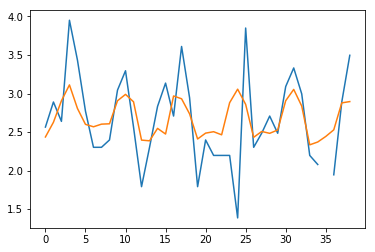

In [29]:
plt.plot(test_truth[129])
plt.plot(testpreds[129])

In [32]:
MSE(test_truth.reshape(-1),testpreds.reshape(-1))

0.27813690899329735

In [29]:
np.sqrt(0.27809914084615828)

0.52735106034420587

In [48]:
lst=[]
for i in range(39):
    lst.append(MSE(test_truth[:,i],testpreds[:,i]))
    d=rrvf_data.idx_to_date([i+478-39])[0]
    print i, d, pd.to_datetime(d).weekday()+1, lst[-1]
np.mean(lst[:8]),np.mean(lst[:]),np.mean(lst[-8:])

0 2017-03-15 3 0.243660975183
1 2017-03-16 4 0.24166409128
2 2017-03-17 5 0.200719194796
3 2017-03-18 6 0.215471674177
4 2017-03-19 7 0.361275279993
5 2017-03-20 1 0.394929993731
6 2017-03-21 2 0.371112504144
7 2017-03-22 3 0.267142761552
8 2017-03-23 4 0.251849986993
9 2017-03-24 5 0.232842378965
10 2017-03-25 6 0.248340951846
11 2017-03-26 7 0.321248571524
12 2017-03-27 1 0.305755779292
13 2017-03-28 2 0.297651015032
14 2017-03-29 3 0.275325253029
15 2017-03-30 4 0.295134113336
16 2017-03-31 5 0.253350390073
17 2017-04-01 6 0.245336126084
18 2017-04-02 7 0.332218728117
19 2017-04-03 1 0.324726795988
20 2017-04-04 2 0.321202797682
21 2017-04-05 3 0.285974209483
22 2017-04-06 4 0.313860086179
23 2017-04-07 5 0.254455157744
24 2017-04-08 6 0.231224277214
25 2017-04-09 7 0.357398886398
26 2017-04-10 1 0.320655449084
27 2017-04-11 2 0.339800484778
28 2017-04-12 3 0.279202854936
29 2017-04-13 4 0.273437200223
30 2017-04-14 5 0.22049889382
31 2017-04-15 6 0.205151845252
32 2017-04-16 7 0.31

(0.28699705935706343, 0.28168850843861498, 0.26354812080397882)

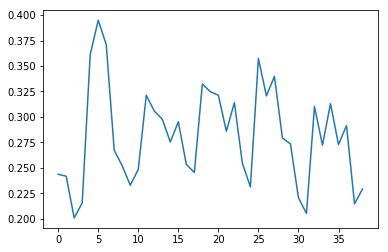

In [33]:
plt.plot(lst)

In [42]:
lst=[]
for i in range(test_truth.shape[0]):
    lst.append(MSE(test_truth[i],testpreds[i]))

In [43]:
lst=np.array(lst)
lst[np.isnan(lst)]=5

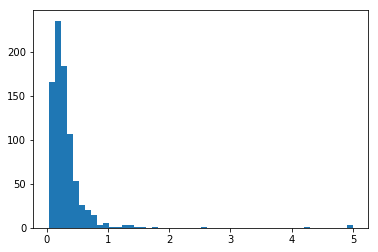

In [44]:
plt.hist(lst,bins=50);

In [33]:
import rrvf_data
lst=[]
for j in validpreds.keys():
    j=10
    u=validpreds[j][0]
    tmpdf=pd.DataFrame(np.array([u[0],u[2],u[1][:,0],u[1][:,1]],copy=False).T)
    tmpdf.columns=['y','ypred','store','day']
    tmpdf['date']=pd.to_datetime(rrvf_data.idx_to_date(tmpdf['day']))
    tmpdf['wd']=tmpdf['date'].map(lambda u: (u.weekday()+j-1)%7+1)
    tmpdf['error']=tmpdf['ypred']-tmpdf['y']
    tmpdf['error2']=tmpdf['error']**2
    tmpdf['roundy']=np.round(tmpdf['y'])
    tmpdf['roundypred']=np.round(tmpdf['ypred'])
    idxes=[tuple(v) for v in u[1].T]    
    for col in columns:
        tmpdf[col]=data[:,:,get_index([col])[0]][idxes]
    break

In [34]:
tmpdf.head()

y     ypred  store    day       date  wd     error    error2  \
0  2.995732  3.415548  665.0  205.0 2016-07-24   2  0.419815  0.176245   
1  1.791759  2.226828  636.0  254.0 2016-09-11   2  0.435069  0.189285   
2  3.258096  3.143642   95.0  197.0 2016-07-16   1 -0.114455  0.013100   
3  1.791759  2.918789  309.0  238.0 2016-08-26   7  1.127030  1.270195   
4  3.178054  3.345082  674.0  233.0 2016-08-21   2  0.167028  0.027898   

   roundy  roundypred   ...     geo2_count_y4  all_count_y5  geo1_count_y5  \
0     3.0         3.0   ...          0.065789           NaN            NaN   
1     2.0         2.0   ...          0.157895      0.001701       0.003401   
2     3.0         3.0   ...          0.190476           NaN            NaN   
3     2.0         3.0   ...          0.111111      0.001321            NaN   
4     3.0         3.0   ...          0.100000           NaN            NaN   

   station_count_y5  geo2_count_y5       TMAX       TMIN       TAVG   PRCP  \
0               NaN            NaN  33.500000  26.700001  29.700001    NaN   
1          0.003448            NaN  25.000000  20.799999  23.100000   36.0   
2               NaN            NaN  27.700001  20.100000  25.100000   46.0   
3               NaN            NaN  33.599998  24.600000  27.400000    NaN   
4               NaN            NaN  30.000000  23.500000  28.400000  551.0   

   holiday  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  

[5 rows x 72 columns]

In [35]:
columns

array(['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2',
       'weekday1', 'weekday0', 'const_one', 'visitors',
       'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean',
       'genre_name_visitors_mean', 'day_of_week_visitors_mean',
       'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91',
       'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4',
       'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56',
       'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2',
       'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16',
       'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28',
       'all_count_y1', 'geo1_count_y1', 'station_count_y1',
       'geo2_count_y1', 'all_count_y2', 'geo1_count_y2',
       'station_count_y2', 'geo2_count_y2', 'all_count_y3',
       'geo1_count_y3', 'station_count_y3', 'geo2_count_y3',
       'all_count_y4', 'geo1_count_y4', 'station_count_y4',
       

In [36]:
import seaborn as sns

In [37]:
def f(col):
    aa=tmpdf[[col,'error2']].groupby(col).sum()/tmpdf['error2'].sum()
    return aa
    #plt.bar(aa.index,aa.values,alpha=0.5);

In [154]:
#sns.kdeplot(tmpdf['y'],tmpdf['error2'])

In [155]:
tmpdf['y'].mean()

2.8381574573754613

In [156]:
tmpdf['error'].var(),tmpdf['error2'].mean()

(0.26409566730973283, 0.26408375270867485)

In [157]:
tmpdf[['wd','error','error2']].groupby('wd').mean()

error    error2
wd                    
1   0.026904  0.303843
2  -0.001729  0.267750
3  -0.004756  0.255938
4  -0.010992  0.238772
5   0.009662  0.227556
6  -0.018687  0.229730
7   0.011973  0.356522

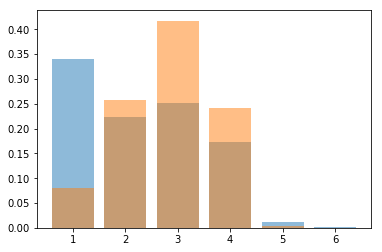

In [145]:
aa=tmpdf[['roundy','error2']].groupby('roundy').sum()/tmpdf['error2'].sum()
plt.bar(aa.index,aa.values,alpha=0.5);
aa=tmpdf['roundy'].value_counts()/tmpdf.shape[0]
plt.bar(aa.index,aa.values,alpha=0.5);
plt.show()
aa=tmpdf[['roundypred','error2']].groupby('roundypred').sum()/tmpdf['error2'].sum()
plt.bar(aa.index,aa.values,alpha=0.5);
aa=tmpdf['roundypred'].value_counts()/tmpdf.shape[0]
plt.bar(aa.index,aa.values,alpha=0.5);

In [77]:
tmpdf[tmpdf['store']==289][['wd','error2']].groupby('wd').mean()

error2
wd          
1   0.354078
2   0.394285
3   0.269970
4   0.408891
5   0.147726
6   0.204076
7   0.268409

In [78]:
tmpdf[tmpdf['store']==163][['wd','error2','y','ypred']].sort_values('error2',ascending=False)

wd    error2         y     ypred
8075    7  4.592850  0.693147  2.836241
18666   4  2.182675  0.693147  2.170535
3507    4  1.862406  0.693147  2.057847
5777    2  1.655395  1.098612  2.385234
16989   4  1.568133  1.098612  2.350863
14478   7  1.449154  0.693147  1.896955
10326   7  1.261013  0.693147  1.816095
19315   4  1.226880  3.135494  2.027848
4216    5  1.211607  2.079442  3.180172
15747   1  1.158895  1.098612  2.175132
15382   7  1.072238  2.995732  1.960243
18074   6  1.030644  3.465736  2.450530
3788    6  0.995768  1.609438  2.607320
19658   7  0.976753  1.098612  2.086920
2633    1  0.976543  2.833213  1.845012
5213    4  0.971313  1.098612  2.084165
13680   2  0.917322  1.098612  2.056382
12462   1  0.881573  1.098612  2.037533
7840    7  0.878023  1.098612  2.035641
2012    7  0.876984  0.693147  1.629622
6032    6  0.843445  3.091043  2.172650
13524   3  0.826836  2.944439  2.035134
20333   2  0.789895  2.772589  1.883828
9108    6  0.788248  1.609438  2.497271
15483   2  0.781922  2.944439  2.060175
1045    2  0.780673  1.098612  1.982169
20056   2  0.779057  2.833213  1.950571
11223   7  0.746348  1.098612  1.962527
14753   1  0.715277  1.098612  1.944353
18914   7  0.676489  2.772589  1.950099
...    ..       ...       ...       ...
18059   5  0.017883  2.639057  2.505330
9173    3  0.015294  2.484907  2.361237
6141    3  0.014194  2.564949  2.684086
17798   6  0.013985  2.484907  2.603166
18726   1  0.013901  1.945910  2.063814
1959    1  0.012474  2.079442  2.191127
7765    2  0.010343  1.945910  2.047611
11000   5  0.010029  2.833213  2.733069
4841    3  0.008874  2.564949  2.470747
18441   5  0.007348  2.639057  2.553339
9969    1  0.006933  2.079442  1.996176
3066    5  0.006731  2.564949  2.646992
14601   5  0.006478  2.397895  2.478378
9358    1  0.006034  2.197225  2.119549
6536    5  0.005166  2.484907  2.413034
16458   6  0.004548  2.708050  2.775492
5308    5  0.003533  2.564949  2.624392
1075    3  0.003238  2.484907  2.541810
20819   3  0.002636  2.197225  2.248569
9386    5  0.002094  2.484907  2.439147
6151    2  0.001751  2.079442  2.037597
3223    5  0.001366  2.772589  2.809547
20178   4  0.001011  2.484907  2.453106
7565    5  0.000607  2.484907  2.509551
10296   4  0.000378  2.197225  2.177784
12685   1  0.000358  1.791759  1.810671
19387   2  0.000130  1.945910  1.957321
309     7  0.000023  2.079442  2.084248
6868    1  0.000007  2.302585  2.305284
18992   3  0.000005  2.197225  2.194989

[217 rows x 4 columns]

In [65]:
str(set(tmpdf['store']))

'set([386.0, 515.0, 388.0, 5.0, 647.0, 520.0, 307.0, 503.0, 11.0, 268.0, 13.0, 398.0, 271.0, 145.0, 146.0, 771.0, 20.0, 814.0, 406.0, 537.0, 665.0, 26.0, 156.0, 773.0, 289.0, 674.0, 163.0, 420.0, 679.0, 92.0, 135.0, 46.0, 176.0, 691.0, 180.0, 309.0, 521.0, 23.0, 116.0, 315.0, 151.0, 446.0, 565.0, 705.0, 195.0, 227.0, 325.0, 327.0, 456.0, 329.0, 587.0, 204.0, 462.0, 707.0, 466.0, 339.0, 724.0, 526.0, 728.0, 729.0, 90.0, 591.0, 604.0, 95.0, 225.0, 443.0, 374.0, 487.0, 744.0, 746.0, 363.0, 236.0, 110.0, 772.0, 19.0, 756.0, 89.0, 119.0, 636.0, 618.0, 254.0, 277.0])'

In [57]:
set(tmpdf['store']).intersection([  4,  17,  18,  22,  65,  68,  78,  79,  83,  90, 100, 106, 119,
        120, 159, 164, 166, 206, 208, 219, 224, 227, 228, 238, 246, 260,
        270, 291, 310, 384, 386, 392, 403, 421, 467, 473, 501, 511, 514,
        520, 521, 523, 530, 567, 596, 598, 609, 616, 630, 646, 650, 657,
        662, 666, 686, 692, 697, 699, 715, 722, 760, 784, 786, 801, 803,
        811, 821, 828])

{90, 119, 227, 386, 520, 521}

In [44]:
tmpdf['store'].max()

814.0

In [64]:
u

(array([ 3.68887949,  3.40119743,  1.60943794, ...,  3.66356158,
         3.33220458,  0.69314718], dtype=float32), array([[443, 302],
        [  5, 217],
        [ 89, 284],
        ..., 
        [707, 232],
        [487, 305],
        [195, 139]]), array([ 2.98862929,  3.17709175,  1.97790918, ...,  3.51460546,
         2.66459733,  2.11880964]))